In [435]:
library(leaps)
library(glmnet)
library(reshape2)
library(ggplot2)
library(corrplot)
library(grDevices)
library(RColorBrewer)
library(plotmo)

## IMPORTATION DES DONNEES

In [436]:
data_tot = read.csv('./Donnees/Plusieurs_pays/Total.csv', header = TRUE)
data_tot = data_tot[-c(47,60)]

Création d'un nouveau dataframe sans les variables `Rating` et `Pays`, utilisé après. on enlève aussi toutes les variables liées aux buts, aux assists et aux key passes.

In [437]:
data = data_tot[,-c(81,82,83,84)]
data_but = data_tot[,-c(34:46,55:60,72:84)]

Création de dataFrames qui contiendront les différentes variables influentes

In [438]:
nb.variables = length(data_but[1,])
#df.variables.rating = data.frame("Noms" = colnames(data), "BIC" = rep(0,nb.variables), "Lasso" = rep(0,nb.variables), 
                          #"ElasticNet" = rep(0,nb.variables))#, "NombreDeButs" = rep(0,nb.variables), 
                                 #"NombreDePoints" = rep(0,nb.variables))

df.variables.points = data.frame("Noms" = colnames(data_but), "BIC" = rep(0,nb.variables), "Lasso" = rep(0,nb.variables), 
                          "ElasticNet" = rep(0,nb.variables)#, "NombreDeButs" = rep(0,nb.variables), 
                                 #"NombreDePoints" = rep(0,nb.variables)
                                )

In [510]:
df.variables.pays = data.frame("Noms" = colnames(data_but), 
                               #"France_BIC" = rep(0,nb.variables), 
                               #"France_LASSO" = rep(0,nb.variables),
                               "France_ElasticNet" = rep(0,nb.variables),
                               #"Espagne_BIC" = rep(0,nb.variables),
                               #"Espagne_LASSO" = rep(0,nb.variables),
                               "Espagne_ElasticNet" = rep(0,nb.variables),
                               #"Italie_BIC" = rep(0,nb.variables), 
                               #"Italie_LASSO" = rep(0,nb.variables), 
                               "Italie_ElasticNet" = rep(0,nb.variables), 
                               #"Argentine_BIC" = rep(0,nb.variables), 
                               #"Argentine_LASSO" = rep(0,nb.variables),
                               "Argentine_ElasticNet" = rep(0,nb.variables),
                               #"Angleterre_BIC" = rep(0,nb.variables), 
                               #"Angleterre_LASSO" = rep(0,nb.variables),
                               "Angleterre_ElasticNet" = rep(0,nb.variables),
                               #"Allemagne_BIC" = rep(0,nb.variables),
                               #"Allemagne_LASSO" = rep(0,nb.variables),
                               "Allemagne_ElasticNet" = rep(0,nb.variables))

## Sélection de variables

### BIC

In [440]:
choixb <- regsubsets(data_tot$Points~., data=data_but,nbest=1, nvmax=10, method="seqrep")
#choixb_buts <- regsubsets(data_tot$Rating~., data=data_but,nbest=1, nvmax=10, method="seqrep")

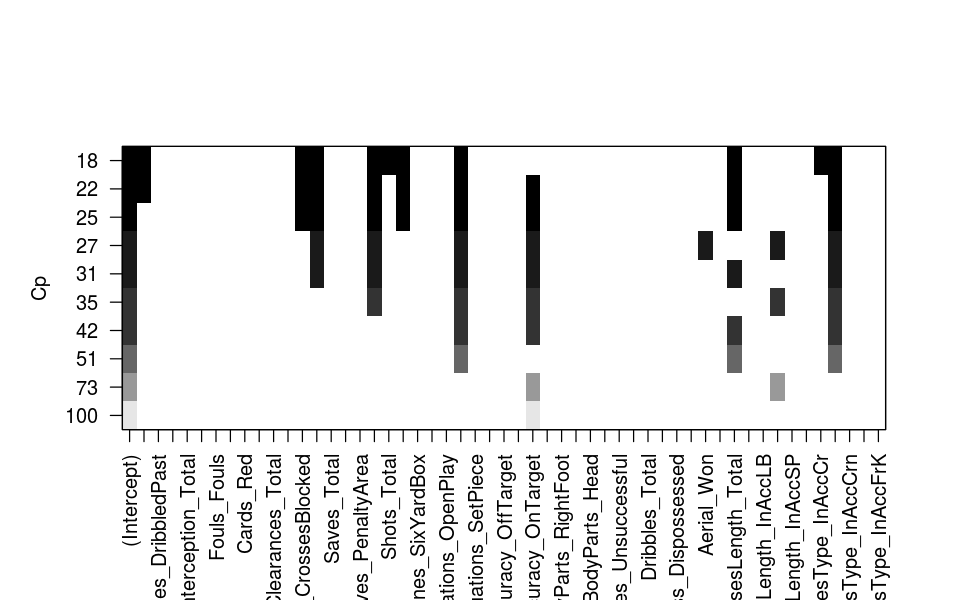

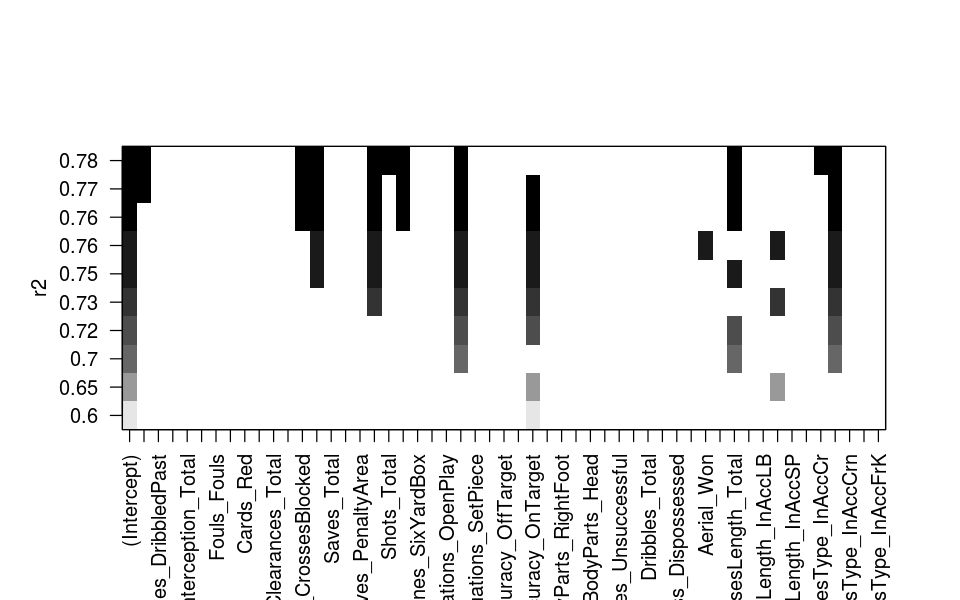

In [441]:
options(repr.plot.width=8, repr.plot.height=5)
plot(choixb,scale="Cp")
plot(choixb,scale="r2")

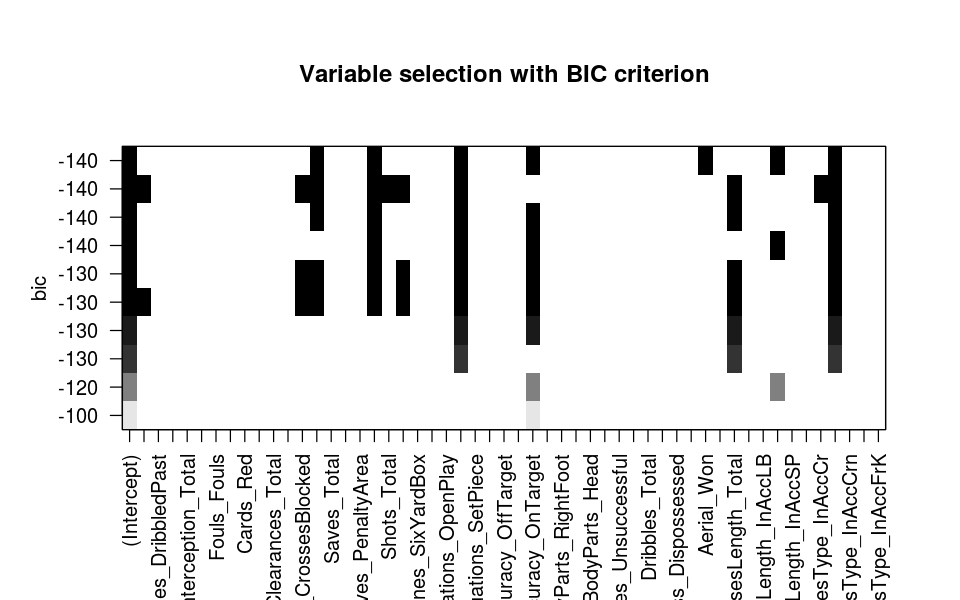

In [442]:
plot(choixb,scale="bic", main = "Variable selection with BIC criterion")

Les trois différents critères utilisés ci-dessus pour la sélection de modèle (Cp de Mallows, R2 et BIC) semblent donner les mêmes résultats.  
Suivant le critère choisi, il faut soit le maximiser (R2), soit le minimiser (Cp et BIC). Dans les deux cas, il s'agit de trouver les variables mises en noir sur la ligne du haut.

In [443]:
nb_min = which.min(summary(choixb)$bic)
vect = round(coef(choixb, nb_min),3)
vect

(Intercept)    Blocks_PassesBlocked          Saves_OutOfBox 
                 -6.593                  -2.335                  -8.581 
shotsSituations_Counter  ShotsAccuracy_OnTarget              Aerial_Won 
                 20.218                   6.277                   0.777 
     PassesLength_AccSP       PassesType_AccCrn 
                  0.062                   6.413

In [444]:
names(vect[-1])

[1] "Blocks_PassesBlocked"    "Saves_OutOfBox"         
[3] "shotsSituations_Counter" "ShotsAccuracy_OnTarget" 
[5] "Aerial_Won"              "PassesLength_AccSP"     
[7] "PassesType_AccCrn"

In [445]:
test_r2_bic = lm(data_tot$Points~Blocks_PassesBlocked + Saves_OutOfBox + shotsSituations_Counter+
                 ShotsAccuracy_OnTarget+Aerial_Won+PassesLength_AccSP+PassesType_AccCrn, data=data_but)

In [446]:
summary(test_r2_bic)


Call:
lm(formula = data_tot$Points ~ Blocks_PassesBlocked + Saves_OutOfBox + 
    shotsSituations_Counter + ShotsAccuracy_OnTarget + Aerial_Won + 
    PassesLength_AccSP + PassesType_AccCrn, data = data_but)

Residuals:
    Min      1Q  Median      3Q     Max 
-22.318  -4.974  -0.421   5.739  25.134 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -6.59327   12.96835  -0.508 0.612130    
Blocks_PassesBlocked    -2.33465    0.84371  -2.767 0.006584 ** 
Saves_OutOfBox          -8.58078    3.48706  -2.461 0.015338 *  
shotsSituations_Counter 20.21794    5.18179   3.902 0.000161 ***
ShotsAccuracy_OnTarget   6.27743    1.56156   4.020 0.000104 ***
Aerial_Won               0.77695    0.32951   2.358 0.020055 *  
PassesLength_AccSP       0.06211    0.01795   3.461 0.000755 ***
PassesType_AccCrn        6.41291    2.05213   3.125 0.002247 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.86

In [447]:
for (i in 1:nb.variables){
    for (j in 1:(length(names(vect))-1)){
        if (choixb$xnames[i+1] == names(vect)[j+1]){
            df.variables.points$BIC[i] = round(vect[j+1],3)
        }
    } 
}

In [448]:
#variables = matrix(, nrow = nrow(data_but), ncol = length(vect)+1)
data_bic = data_tot$Points
noms = "Points"
for (i in 1:(length(vect)-1)){
    text = names(vect)[i+1]
    data_bic = cbind(data_bic,data_but[text])
    noms = c(noms, text)
}

In [449]:
names(data_bic)[1] = "Points"

In [450]:
data_bic

,Points,Blocks_PassesBlocked,Saves_OutOfBox,shotsSituations_Counter,ShotsAccuracy_OnTarget,Aerial_Won,PassesLength_AccSP,PassesType_AccCrn
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Paris Saint-Germain,91,6.4,1.2,0.8,6.1,11.0,529.2,3.2
Lyon,75,7.1,1.2,0.6,6.6,16.6,445.2,2.8
Lille,72,7.1,0.9,0.8,5.1,15.4,331.3,1.7
Montpellier,66,8.1,1.2,0.5,4.5,20.3,291.1,1.8
Saint-Etienne,61,6.9,1.1,0.2,4.7,16.6,336.1,2.6
Marseille,59,6.5,0.9,0.3,4.5,18.9,363.6,2.5
Nice,56,8.0,1.2,0.6,3.4,14.3,420.9,2.1
Nimes,55,6.8,1.1,0.5,4.7,19.2,239.3,2.0
Rennes,53,7.5,1.1,0.6,4.2,17.1,317.4,2.1


In [451]:
reg_bic = lm(Points~(.)^2, data = data_bic)

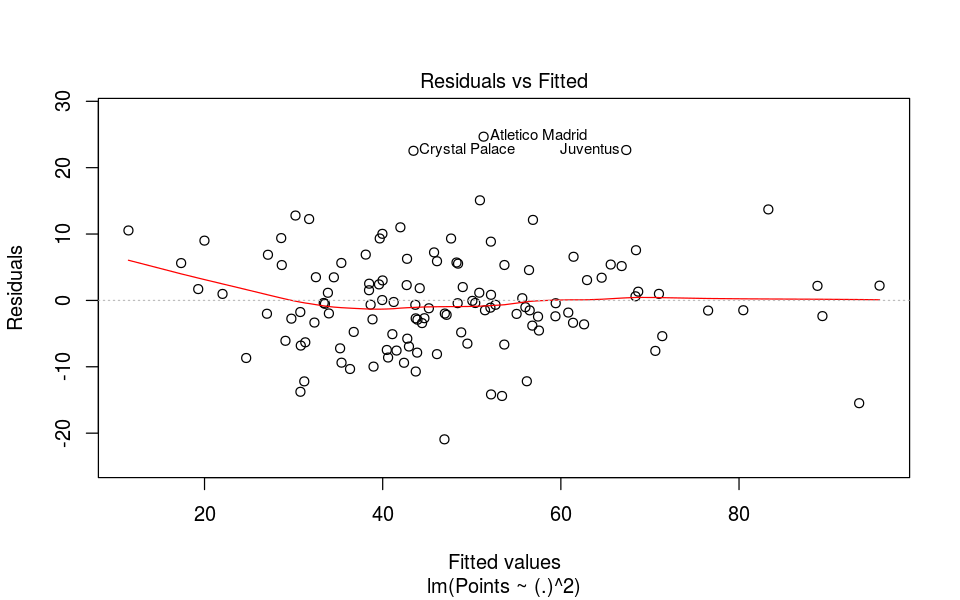

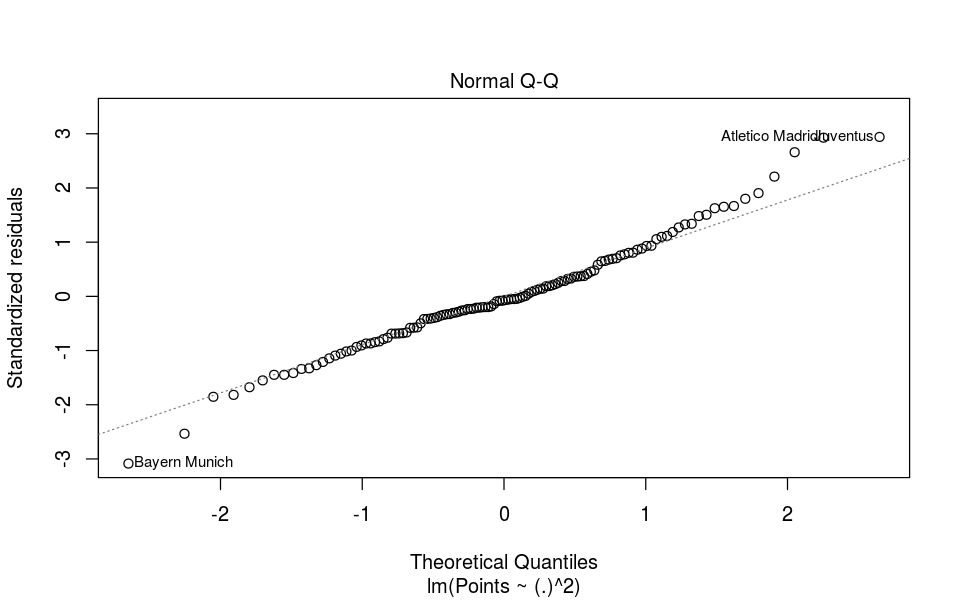

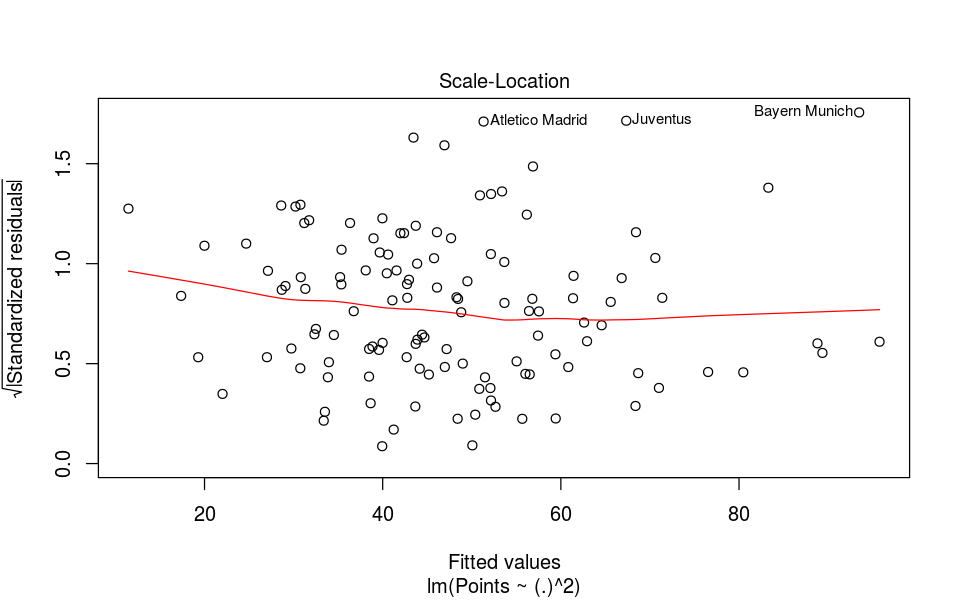

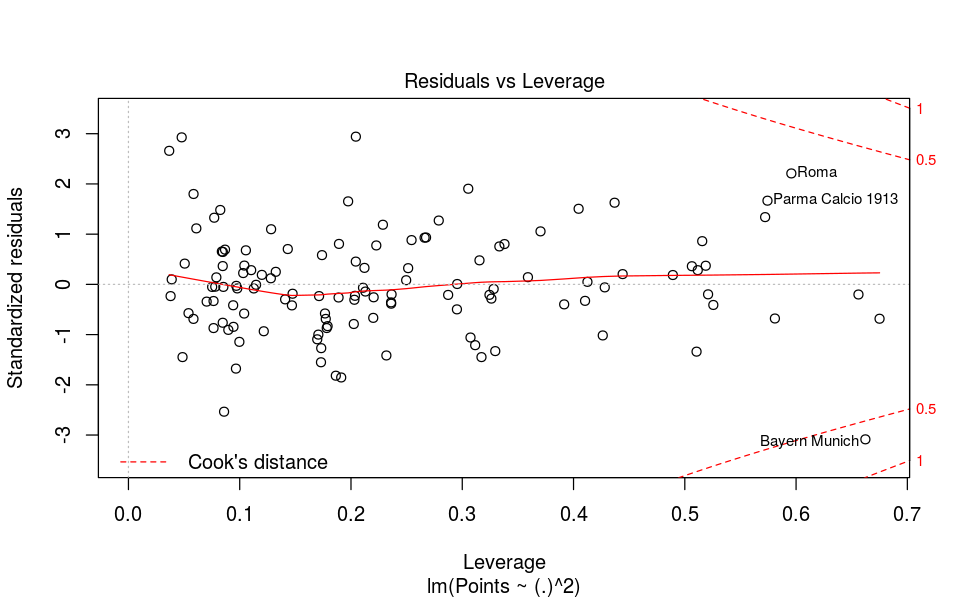

In [452]:
plot(reg_bic)

On voit que le graphe des résidus ne présente pas de forme particulière. De plus, le graphe quantile-quantile est plus ou moins aligné (quelques soucis sur les petits et grands quantiles).

On va refaire de la sélection de variables, mais pour chaque pays, et ainsi observer les variables vraiment influentes.

### Par pays

In [453]:
France = data_but[data_tot$Pays == "France",]
Allemagne = data_but[data_tot$Pays == "Allemagne",]
Italie = data_but[data_tot$Pays == "Italie",]
Espagne = data_but[data_tot$Pays == "Espagne",]
Argentine = data_but[data_tot$Pays == "Argentine",]
Angleterre = data_but[data_tot$Pays == "Angleterre",]

In [454]:
choix_France <- regsubsets(data_tot[data_tot$Pays=="France",]$Points~., data=France,nbest=1, nvmax=10, method="seqrep")
choix_Allemagne <- regsubsets(data_tot[data_tot$Pays=="Allemagne",]$Points~., data=Allemagne,nbest=1, nvmax=10, method="seqrep")
choix_Italie <- regsubsets(data_tot[data_tot$Pays=="Italie",]$Points~., data=Italie,nbest=1, nvmax=10, method="seqrep")
choix_Espagne <- regsubsets(data_tot[data_tot$Pays=="Espagne",]$Points~., data=Espagne,nbest=1, nvmax=10, method="seqrep")
choix_Argentine <- regsubsets(data_tot[data_tot$Pays=="Argentine",]$Points~., data=Argentine, nbest=1, nvmax=10, method="seqrep")
choix_Angleterre <- regsubsets(data_tot[data_tot$Pays=="Angleterre",]$Points~., data=Angleterre, nbest=1, nvmax=10, method="seqrep")

Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“33  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“35  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“33  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“33  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“27  linear dependencies found”
Warning message in leaps.setup(x, y, wt = wt, nbest = nbest, nvmax = nvmax, force.in = force.in, :
“33  linear dependencies found”


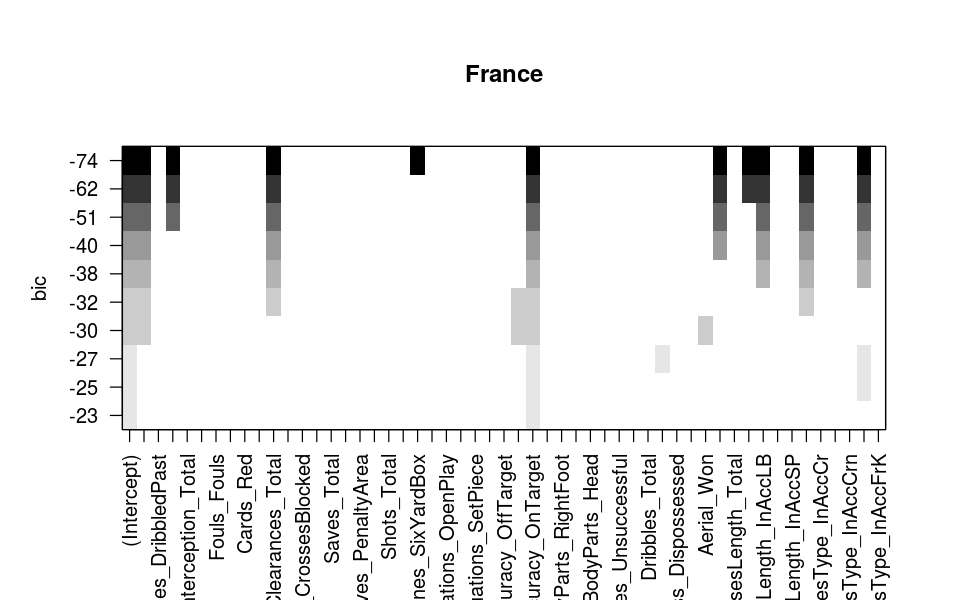

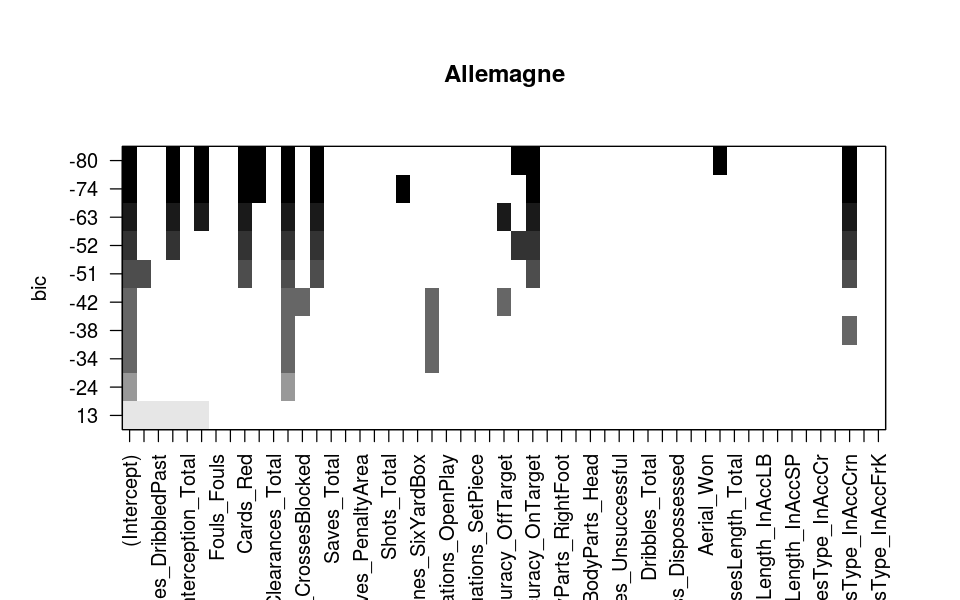

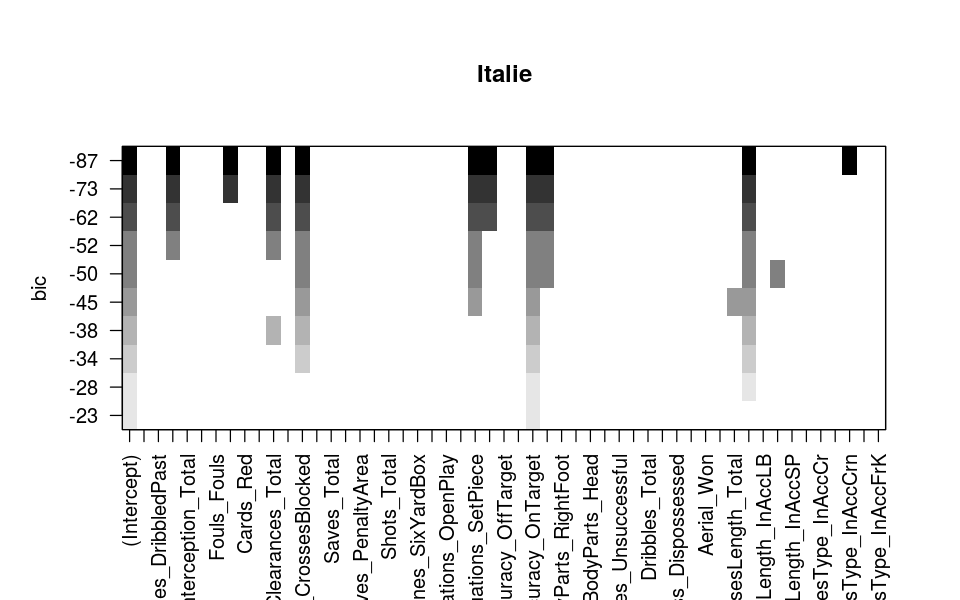

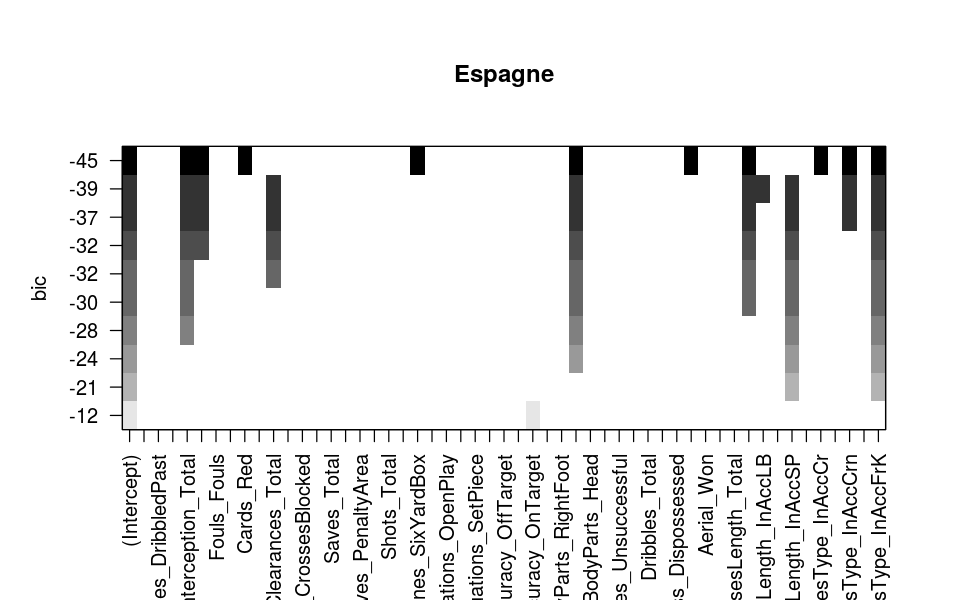

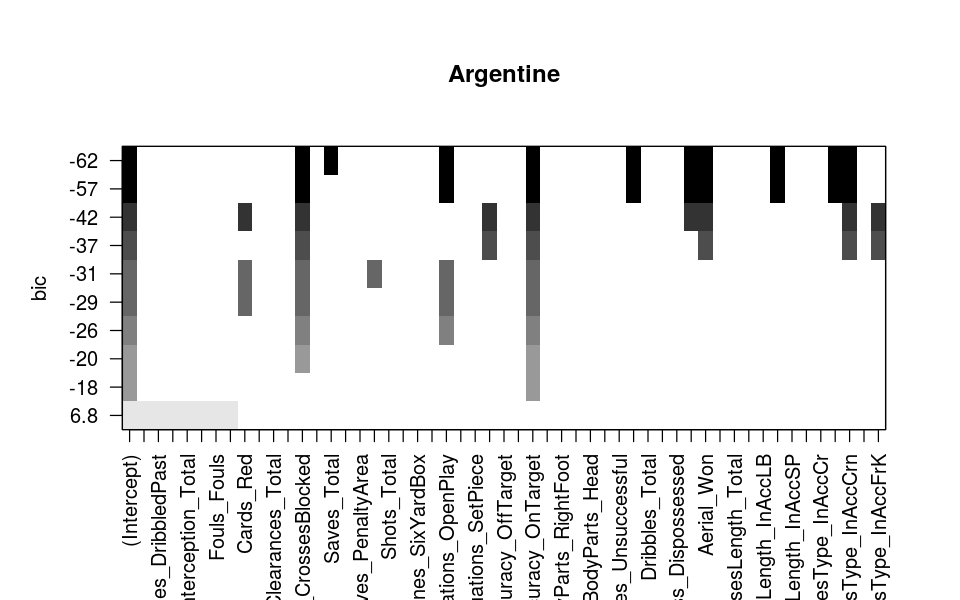

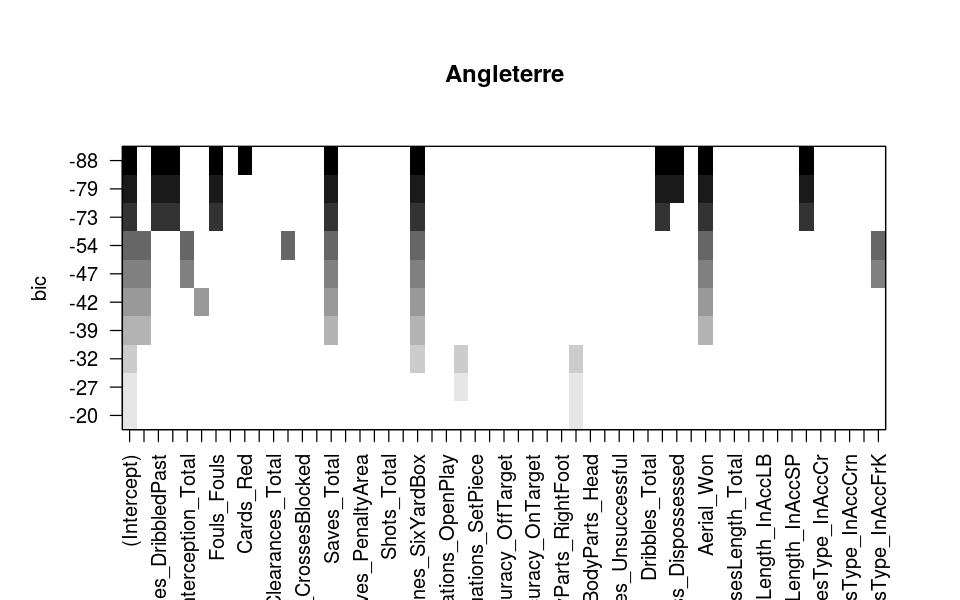

In [455]:
plot(choix_France,scale="bic", main = "France")
plot(choix_Allemagne,scale="bic", main = "Allemagne")
plot(choix_Italie,scale="bic", main = "Italie")
plot(choix_Espagne,scale="bic", main = "Espagne")
plot(choix_Argentine,scale="bic", main = "Argentine")
plot(choix_Angleterre,scale="bic", main = "Angleterre")

On voit que les variables retenues ne sont pas les mêmes d'un pays à l'autre. On va les afficher.

In [456]:
nb_min = which.min(summary(choix_France)$bic)
c_fr = coef(choix_France, nb_min)
c_fr

(Intercept)          Tackles_TotalTackles 
                  -77.9302404                     9.7212844 
Tackles_TotalAttemptedTackles              Clearances_Total 
                   -3.3966718                    -2.7504201 
        ShotsZones_SixYardBox        ShotsAccuracy_OnTarget 
                    7.2707977                    13.4119080 
                  Aerial_Lost            PassesLength_AccLB 
                   -1.8131083                     0.4089274 
         PassesLength_InAccLB              PassesType_AccCr 
                    2.1615077                    -9.6510656 
            PassesType_AccFrK 
                    3.8453056

In [457]:
nb_min = which.min(summary(choix_Allemagne)$bic)
c_al = coef(choix_Allemagne, nb_min)
c_al

(Intercept) Tackles_TotalAttemptedTackles 
                   122.437577                     -1.809958 
                 Fouls_Fouled                     Cards_Red 
                    -2.012829                    -36.929599 
       OffSides_CaughtOffside           Blocks_ShotsBlocked 
                    -5.508213                    -16.316983 
         Blocks_PassesBlocked          ShotsAccuracy_OnPost 
                     6.183806                    -24.638845 
       ShotsAccuracy_OnTarget                   Aerial_Lost 
                     9.164573                     -0.553496 
          PassesType_InAccCrn 
                    -8.962804

In [458]:
nb_min = which.min(summary(choix_Italie)$bic)
c_it = coef(choix_Italie, nb_min)
c_it

(Intercept) Tackles_TotalAttemptedTackles 
                   -24.524330                     -1.271012 
                 Cards_Yellow              Clearances_Total 
                     9.383821                     -3.315330 
        Blocks_CrossesBlocked      ShotsSituations_SetPiece 
                    24.034917                      5.990969 
 ShotsSituations_PenaltyTaken        ShotsAccuracy_OnTarget 
                   -47.434759                     18.478151 
        ShotsAccuracy_Blocked            PassesLength_AccLB 
                   -11.782979                      1.160746 
          PassesType_InAccCrn 
                     3.676410

In [459]:
nb_min = which.min(summary(choix_Espagne)$bic)
c_esp = coef(choix_Espagne, nb_min)
c_esp 

(Intercept)      Interception_Total            Fouls_Fouled 
            -152.189699                4.461628                1.831048 
              Cards_Red   ShotsZones_SixYardBox ShotsBodyParts_LeftFoot 
              17.085778               11.885149                5.589398 
           Aerial_Total      PassesLength_AccLB      PassesType_InAccCr 
               1.654908                2.619762               -4.827258 
    PassesType_InAccCrn     PassesType_InAccFrK 
              18.501416               -7.163341

In [460]:
nb_min = which.min(summary(choix_Argentine)$bic)
c_arg = coef(choix_Argentine, nb_min)
c_arg

(Intercept)    Blocks_CrossesBlocked              Saves_Total 
           -123.17442829              17.14168453               2.57811326 
ShotsSituations_OpenPlay   ShotsAccuracy_OnTarget      Dribbles_Successful 
              2.92400391               6.33824469              -1.54983187 
            Aerial_Total               Aerial_Won       PassesLength_AccSP 
             -1.31814903               3.29061313               0.08502539 
       PassesType_AccCrn      PassesType_InAccCrn 
             10.57447458               9.20099265

In [461]:
nb_min = which.min(summary(choix_Angleterre)$bic)
c_ang = coef(choix_Angleterre, nb_min)
c_ang

(Intercept)              Tackles_DribbledPast 
                        37.760075                        -10.712119 
    Tackles_TotalAttemptedTackles                       Fouls_Fouls 
                         6.235103                         -1.516796 
                        Cards_Red                       Saves_Total 
                       -32.987936                        -13.455523 
            ShotsZones_SixYardBox PossesionLoss_UnsuccessfulTouches 
                        48.356627                          4.732967 
       PossesionLoss_Dispossessed                        Aerial_Won 
                        -1.472072                         -2.124948 
                 PassesType_AccCr 
                       -14.049887

for (i in 1:nb.variables){
    for (j in 1:(length(names(c_fr))-1)){
        if (choix_France$xnames[i+1] == names(c_fr)[j+1]){
            df.variables.pays$France_BIC[i] = round(c_fr[j+1],3)
        }
        else if (choix_Allemagne$xnames[i+1] == names(c_al)[j+1]){
            df.variables.pays$Allemagne_BIC[i] = round(c_al[j+1],3)
        }
        else if (choix_Angleterre$xnames[i+1] == names(c_ang)[j+1]){
            df.variables.pays$Angleterre_BIC[i] = round(c_ang[j+1],3)
        }
        else if (choix_Argentine$xnames[i+1] == names(c_arg)[j+1]){
            df.variables.pays$Argentine_BIC[i] = round(c_arg[j+1],3)
        }
        else if (choix_Italie$xnames[i+1] == names(c_it)[j+1]){
            df.variables.pays$Italie_BIC[i] = round(c_it[j+1],3)
        }
        else if (choix_Espagne$xnames[i+1] == names(c_esp)[j+1]){
            df.variables.pays$Espagne_BIC[i] = round(c_esp[j+1],3)
        }
    } 
}

On remarque que c'est seulement en France, Allemagne et Espagne que la variable `Goals_Total` est sélectionnée.

# Regression LASSO

### Sur le data frame total, tous pays confondus

alpha=1 is the lasso penalty, and alpha=0 the ridge penalty

In [462]:
m_lasso = glmnet(as.matrix(data_but), data_tot$Points, alpha = 1, nlambda = 100)

53 x 1 sparse Matrix of class "dgCMatrix"
                                             1
(Intercept)                       -10.88939351
Tackles_TotalTackles                1.41912886
Tackles_DribbledPast               -0.21863034
Tackles_TotalAttemptedTackles       .         
Interception_Total                  .         
Fouls_Fouled                        0.17961517
Fouls_Fouls                         .         
Cards_Yellow                        .         
Cards_Red                           .         
OffSides_CaughtOffside             -2.20915650
Clearances_Total                   -0.11534121
Blocks_ShotsBlocked                 .         
Blocks_CrossesBlocked               3.43899506
Blocks_PassesBlocked               -1.52612233
Saves_Total                        -1.74791185
Saves_SixYardBox                    .         
Saves_PenaltyArea                   .         
Saves_OutOfBox                     -5.76293098
Shots_Total                         .         
ShotsZones_OutOfBo

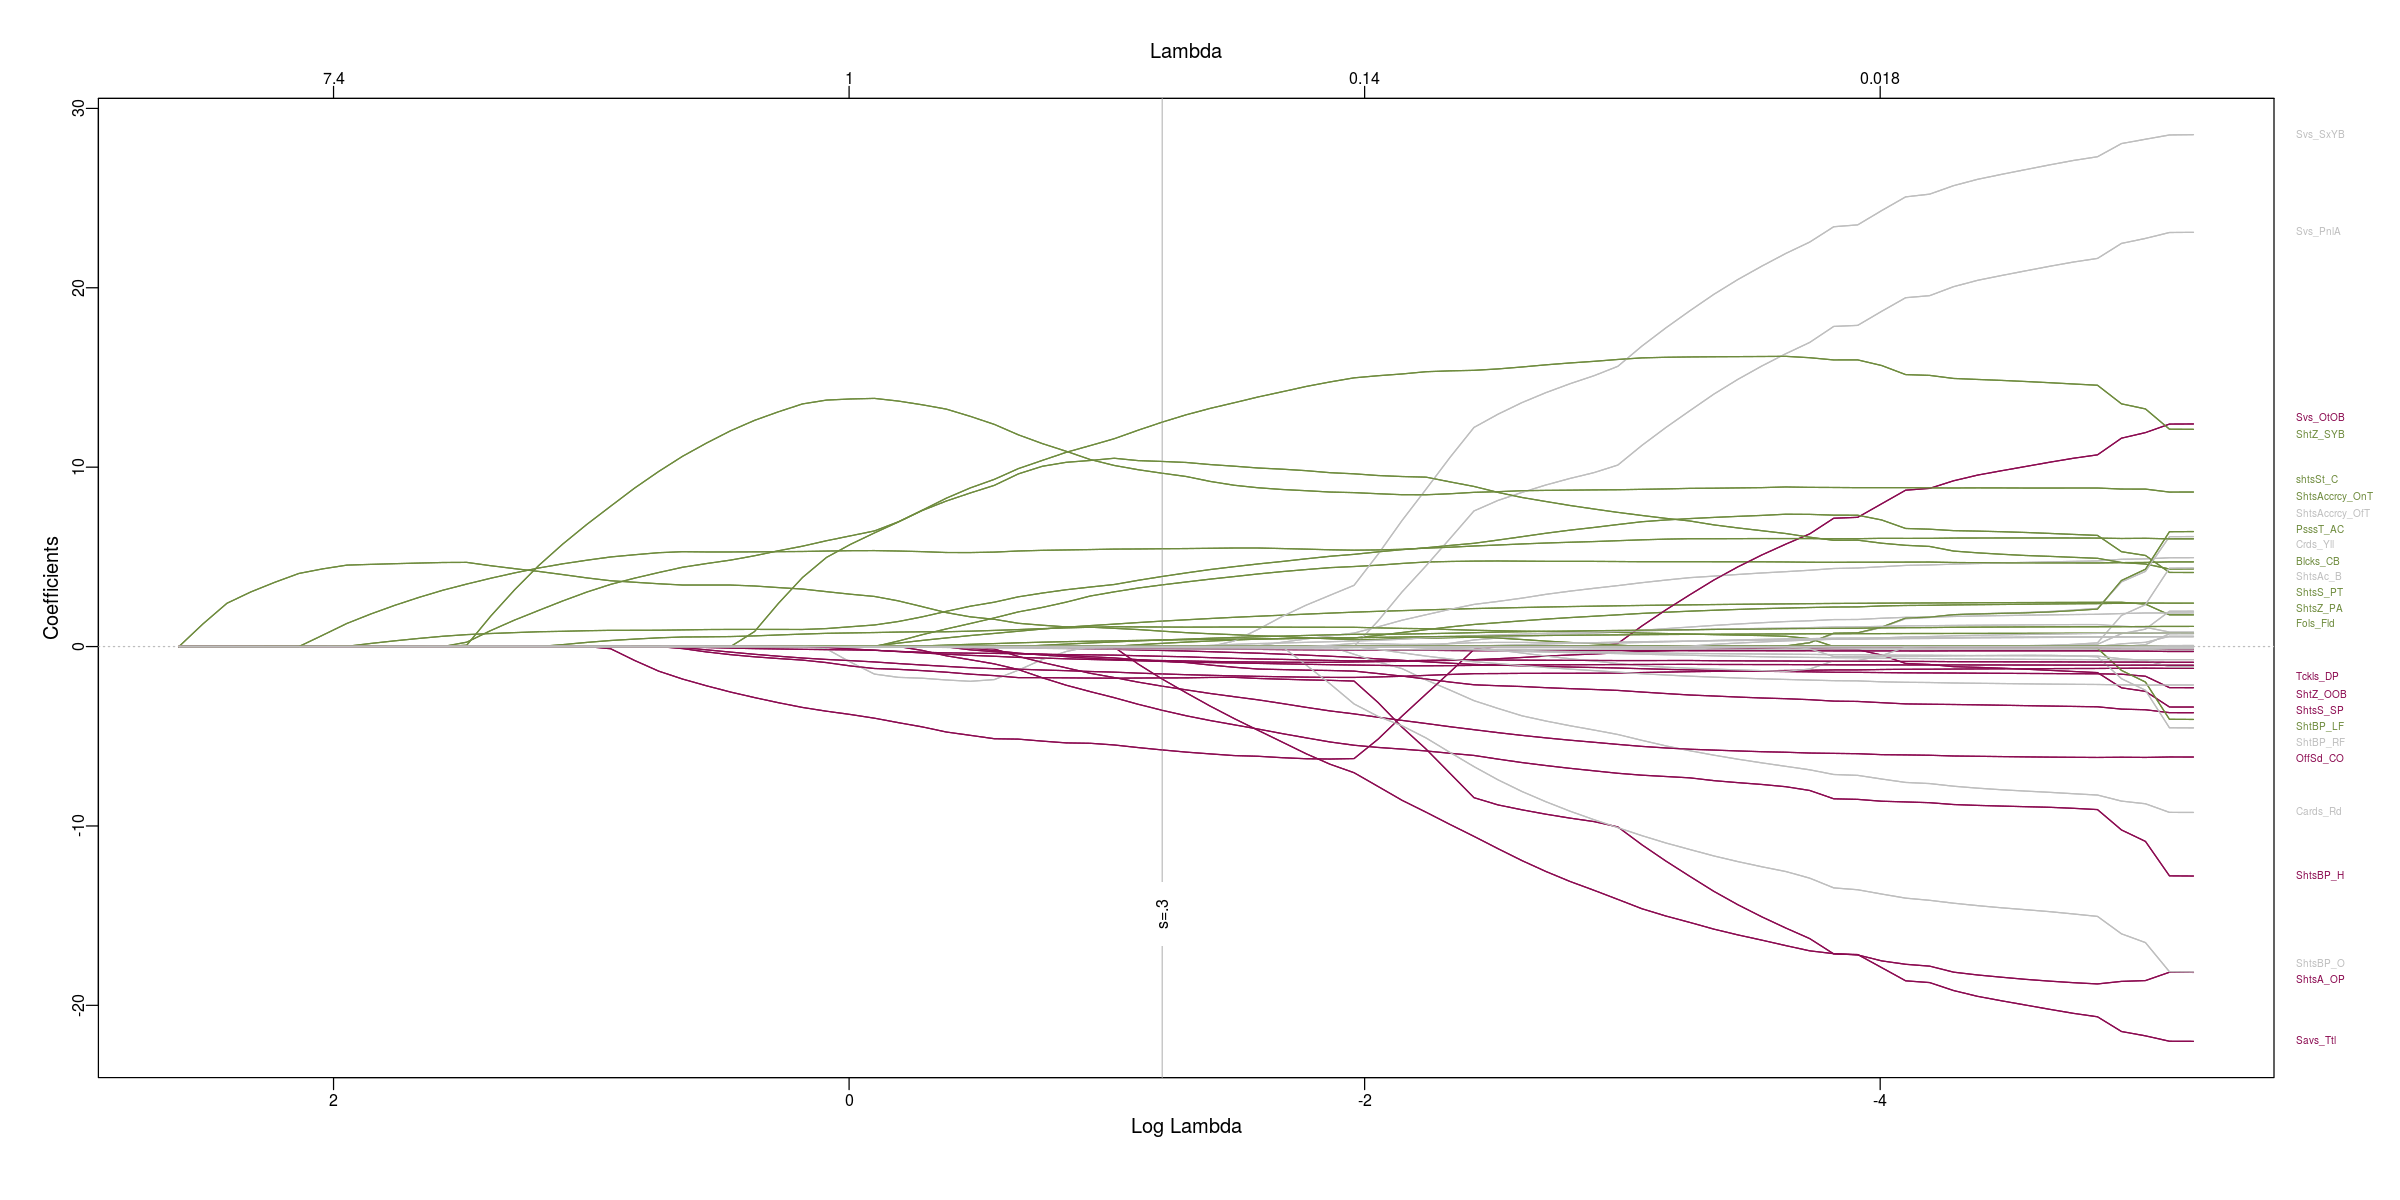

In [463]:
#mod <- glmnet(as.matrix(mtcars[-1]), mtcars[,1]) #from stephen's code above

cvfit<-cv.glmnet(as.matrix(data_but),data_tot$Points)

glmcoef<-coef(m_lasso,cvfit$lambda.min)
coef.increase<-dimnames(glmcoef[glmcoef[,1]>0,0])[[1]]
coef.decrease<-dimnames(glmcoef[glmcoef[,1]<0,0])[[1]]

#get ordered list of variables as they appear at smallest lambda
allnames<-names(coef(m_lasso)[,
    ncol(coef(m_lasso))][order(coef(m_lasso)[,
    ncol(coef(m_lasso))],decreasing=TRUE)])

#remove intercept
allnames<-setdiff(allnames,allnames[grep("Intercept",allnames)])

#assign colors
cols<-rep("gray",length(allnames))
cols[allnames %in% coef.increase]<-"darkolivegreen4"      # higher mpg is good
cols[allnames %in% coef.decrease]<-"deeppink4"        # lower mpg is not

options(repr.plot.width=20, repr.plot.height=10)
plot_glmnet(m_lasso,label=25,s=cvfit$lambda.min,col=cols, cex = 67)

#if you don't believe hp or am are non-zero look at glmcoef
glmcoef

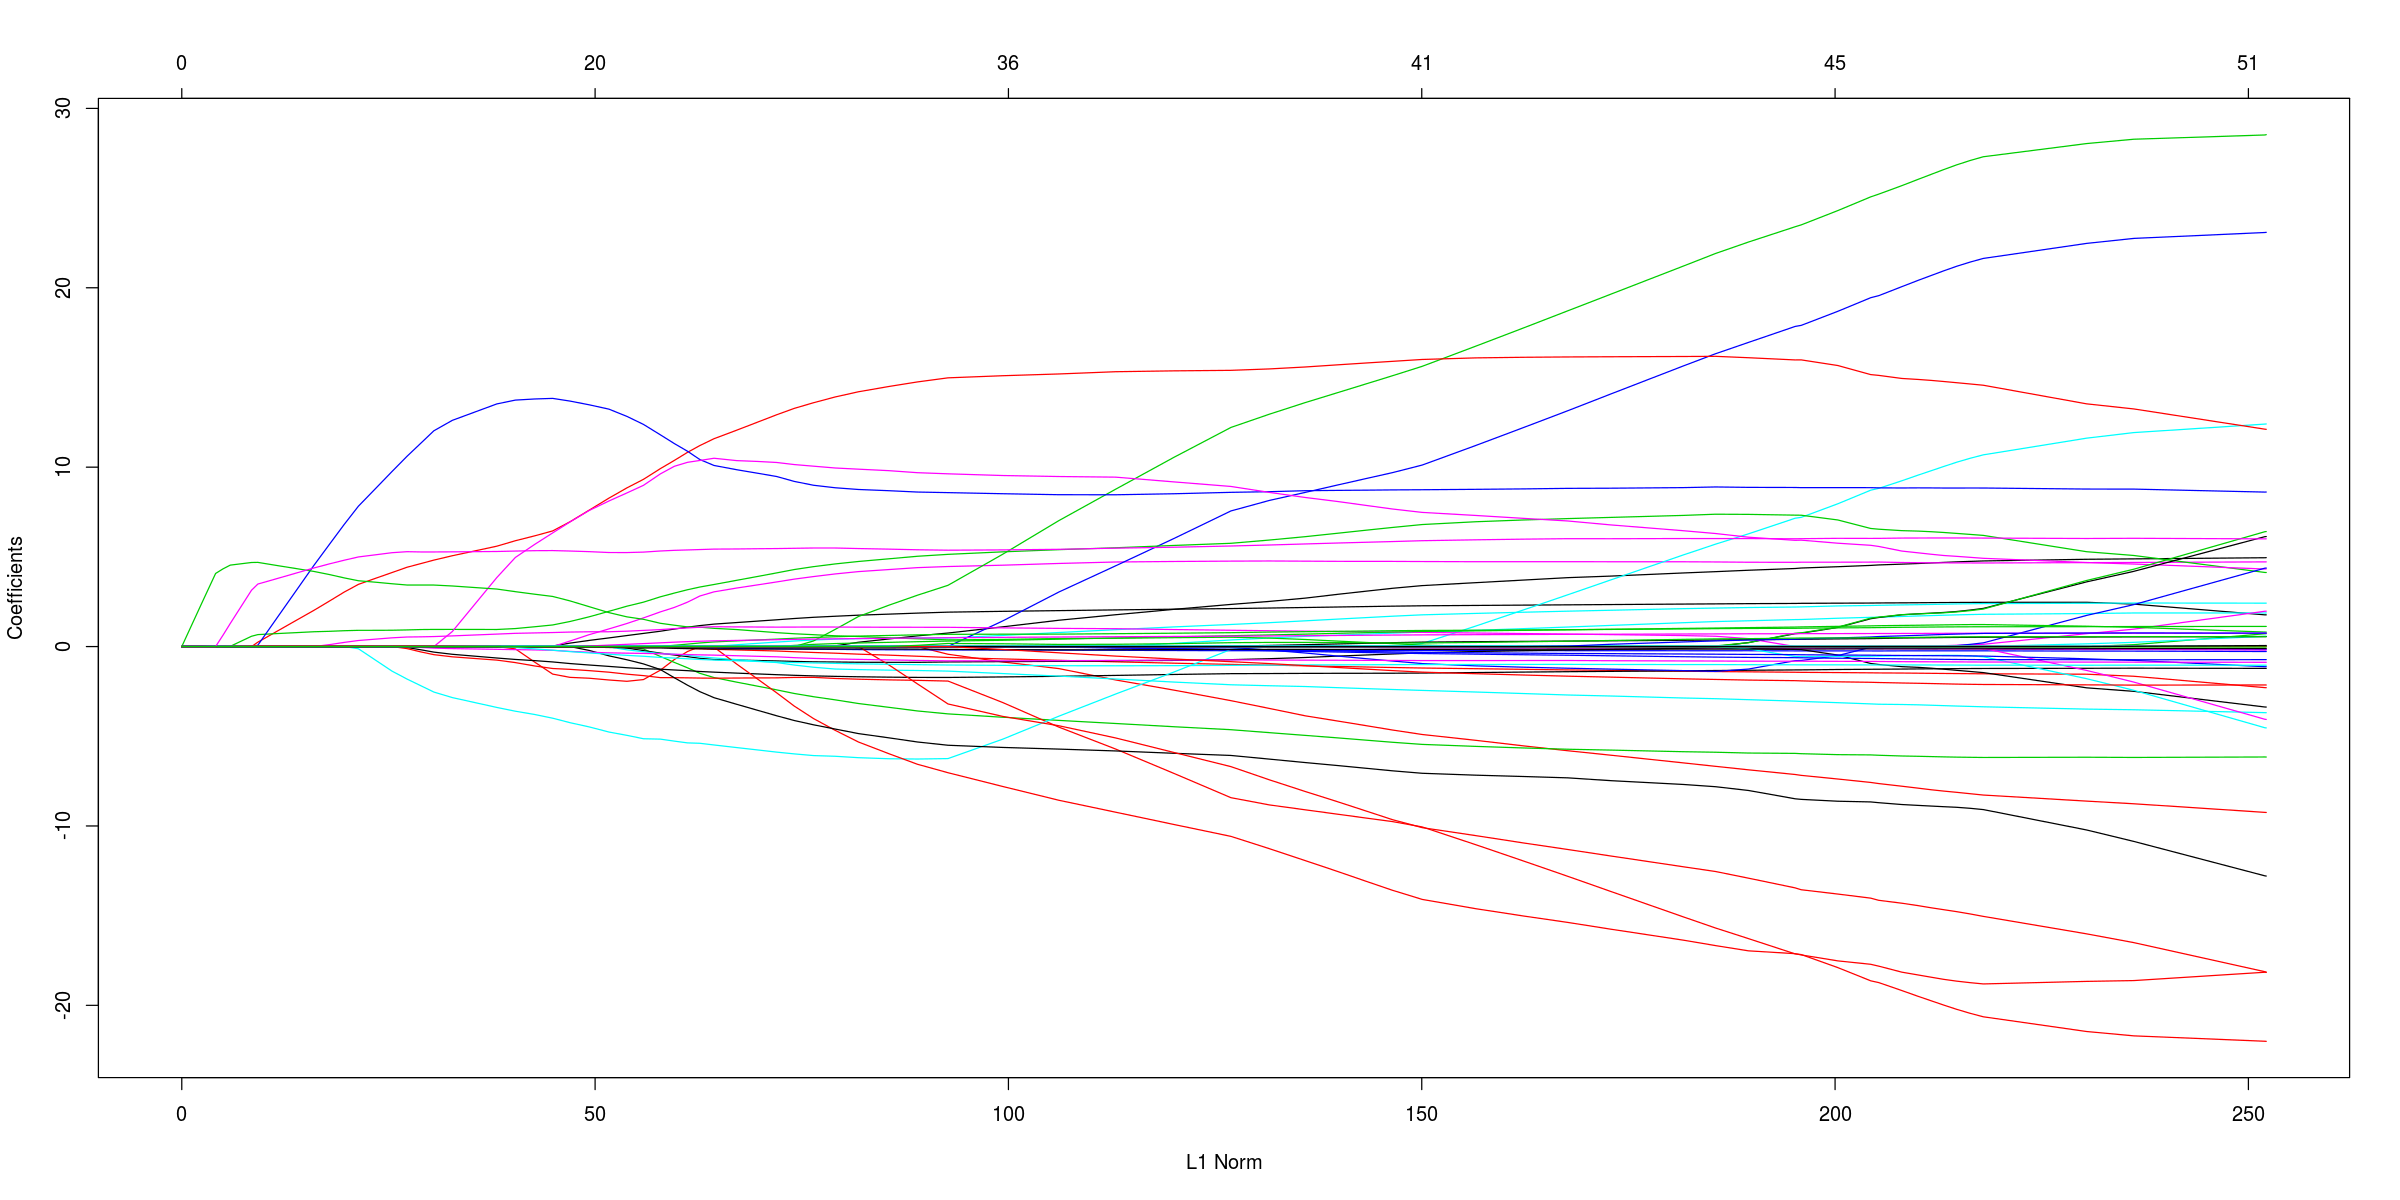

In [464]:
plot(m_lasso)

#### Cross validation

In [465]:
cv.out <- cv.glmnet(as.matrix(data_but), data_tot$Points, alpha = 1)

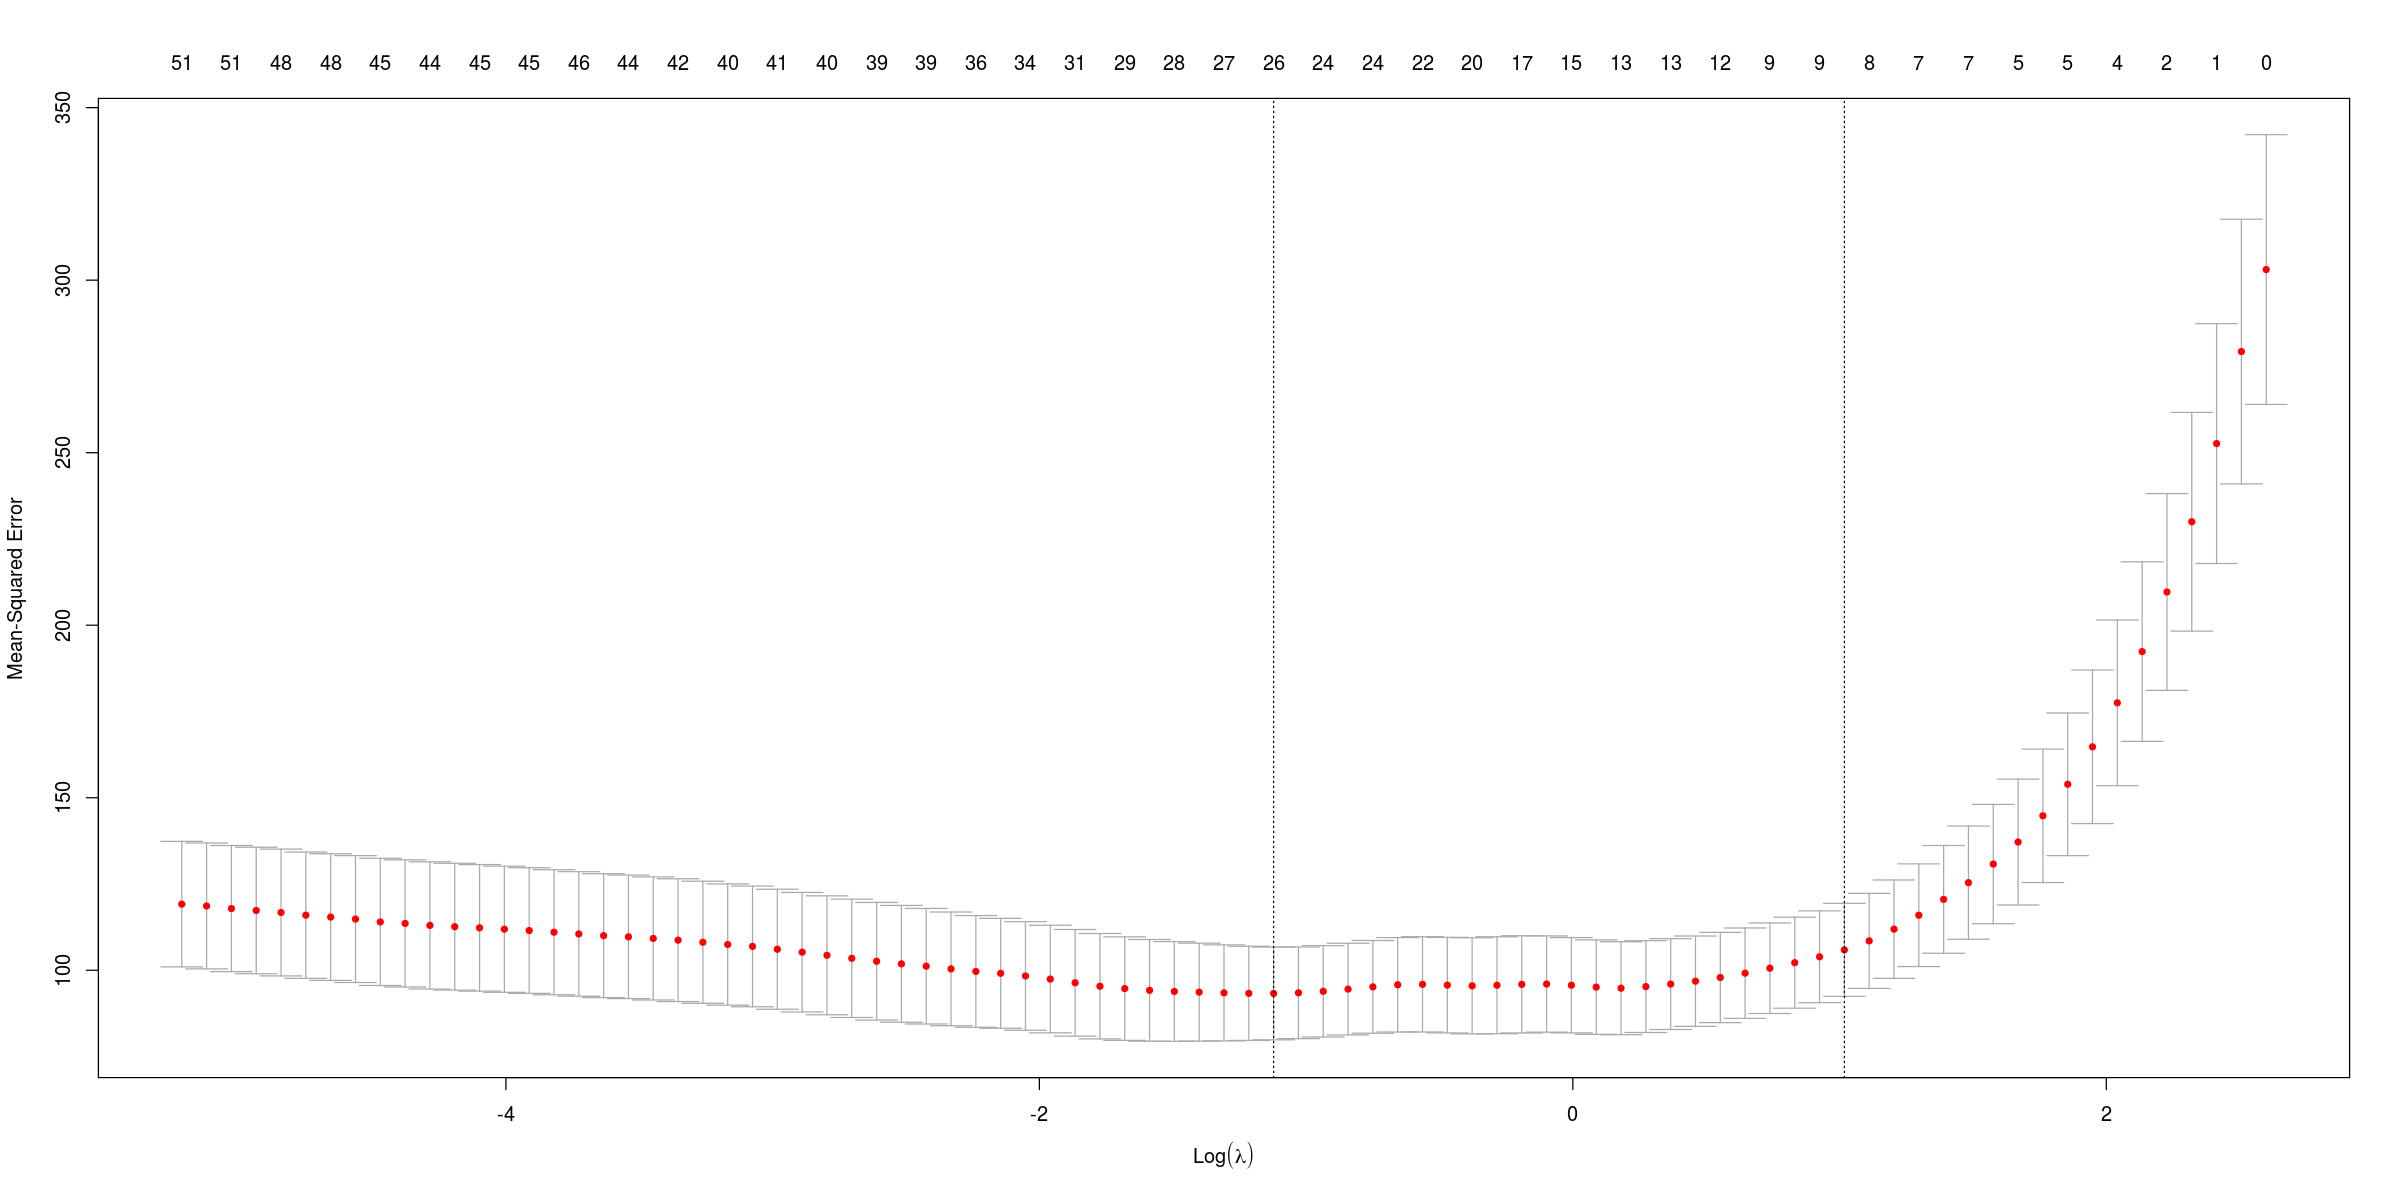

In [466]:
plot(cv.out)

In [467]:
bestlam <- cv.out$lambda.min

In [468]:
lasso.predict = predict(m_lasso, type = "coefficients", s = bestlam)
lasso.predict

53 x 1 sparse Matrix of class "dgCMatrix"
                                           1
(Intercept)                       -9.0415877
Tackles_TotalTackles               1.3386077
Tackles_DribbledPast              -0.1876321
Tackles_TotalAttemptedTackles      .        
Interception_Total                 .        
Fouls_Fouled                       0.1020408
Fouls_Fouls                        .        
Cards_Yellow                       .        
Cards_Red                          .        
OffSides_CaughtOffside            -1.9845864
Clearances_Total                  -0.1049147
Blocks_ShotsBlocked                .        
Blocks_CrossesBlocked              3.2633654
Blocks_PassesBlocked              -1.4806082
Saves_Total                       -1.7543324
Saves_SixYardBox                   .        
Saves_PenaltyArea                  .        
Saves_OutOfBox                    -5.6316219
Shots_Total                        .        
ShotsZones_OutOfBox               -0.7543022
ShotsZones_Si


Call:  cv.glmnet(x = as.matrix(data_but), y = data_tot$Points, alpha = 1) 

Measure: Mean-Squared Error 

    Lambda Measure    SE Nonzero
min 0.3257   93.28 13.44      26
1se 2.7678  105.92 13.47       8

In [469]:
lasso.summary = summary(lasso.predict)

In [470]:
for (i in 1:(length(lasso.summary[,1])-1)){
    df.variables.points$Lasso[lasso.summary[i+1,1]-1] = round(lasso.summary[i+1,3],3)
}

In [471]:
df.variables.points

Noms,BIC,Lasso,ElasticNet
<fct>,<dbl>,<dbl>,<dbl>
Tackles_TotalTackles,0.000,1.339,0
Tackles_DribbledPast,0.000,-0.188,0
Tackles_TotalAttemptedTackles,0.000,0.000,0
Interception_Total,0.000,0.000,0
Fouls_Fouled,0.000,0.102,0
Fouls_Fouls,0.000,0.000,0
Cards_Yellow,0.000,0.000,0
Cards_Red,0.000,0.000,0
OffSides_CaughtOffside,0.000,-1.985,0


In [472]:
data_but

,Tackles_TotalTackles,Tackles_DribbledPast,Tackles_TotalAttemptedTackles,Interception_Total,Fouls_Fouled,Fouls_Fouls,Cards_Yellow,Cards_Red,OffSides_CaughtOffside,Clearances_Total,⋯,PassesLength_AccLB,PassesLength_InAccLB,PassesLength_AccSP,PassesLength_InAccSP,PassesType_AccCr,PassesType_InAccCr,PassesType_AccCrn,PassesType_InAccCrn,PassesType_AccFrK,PassesType_InAccFrK
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Paris Saint-Germain,18.4,9.0,27.5,9.0,11.7,12.05,1.7,0.1,2.4,12.9,⋯,23.1,13.1,529.2,55.9,3.4,12.0,3.2,3.1,10.5,0.9
Lyon,16.8,6.9,23.6,9.6,12.3,11.70,1.4,0.1,2.5,16.1,⋯,26.1,19.6,445.2,57.6,5.2,12.8,2.8,3.1,10.2,1.2
Lille,16.5,8.4,24.9,10.2,13.4,12.60,1.8,0.1,1.0,17.9,⋯,23.9,29.8,331.3,53.2,3.9,11.3,1.7,2.6,10.8,2.8
Montpellier,20.0,9.8,29.8,12.8,12.6,14.10,1.6,0.1,1.5,18.6,⋯,36.2,31.6,291.1,57.8,5.1,14.6,1.8,2.7,9.7,2.6
Saint-Etienne,17.7,9.3,27.0,11.6,12.0,11.90,1.6,0.2,1.6,19.3,⋯,31.8,32.8,336.1,53.2,4.4,15.9,2.6,3.3,8.7,3.5
Marseille,20.5,10.0,30.5,10.6,12.0,13.20,2.2,0.2,1.2,17.0,⋯,26.6,27.2,363.6,56.3,5.7,16.1,2.5,3.4,9.2,2.7
Nice,17.4,8.7,26.1,11.8,13.6,11.20,1.9,0.1,1.1,19.3,⋯,27.6,24.1,420.9,49.1,3.3,9.7,2.1,2.5,12.9,1.6
Nimes,19.3,11.4,30.6,11.7,13.0,12.80,1.8,0.1,1.1,20.4,⋯,27.5,35.8,239.3,56.1,4.5,14.8,2.0,3.3,7.9,4.8
Rennes,17.2,9.4,26.6,10.2,12.8,12.90,1.7,0.1,1.6,19.2,⋯,27.0,27.2,317.4,52.7,3.8,13.7,2.1,2.9,9.3,1.7


Les variables qu'il semble intéressant de retenir, d'après le modèle de régression Lasso, pour l'ensemble des données, sont :   
Tackles_TotalTackles ; Interception_Total ; Cards_Red ; Blocks_CrossesBlocked ;
Blocks_PassesBlocked ; Saves_Total ; Saves_SixYardBox ; shotsSituations_Counter ; ShotsAccuracy_OffTarget ;
GoalsZones_PenaltyArea ; GoalsSituations_PenaltyScored ; GoalsSituations_Own ; GoalsSituations_Normal ;
Dribbles_Total ; PossesionLoss_UnsuccessfulTouches ; Aerial_Won ; PassesLength_Total ; PassesLength_AccLB ; 
PassesType_AccCrn ; KeyPassesLength_Short ; KeyPassesType_Throughball

## Régression Elastic Net

In [473]:
m_enet = glmnet(as.matrix(data_but), data_tot$Points, alpha = 0.5, nlambda = 100)

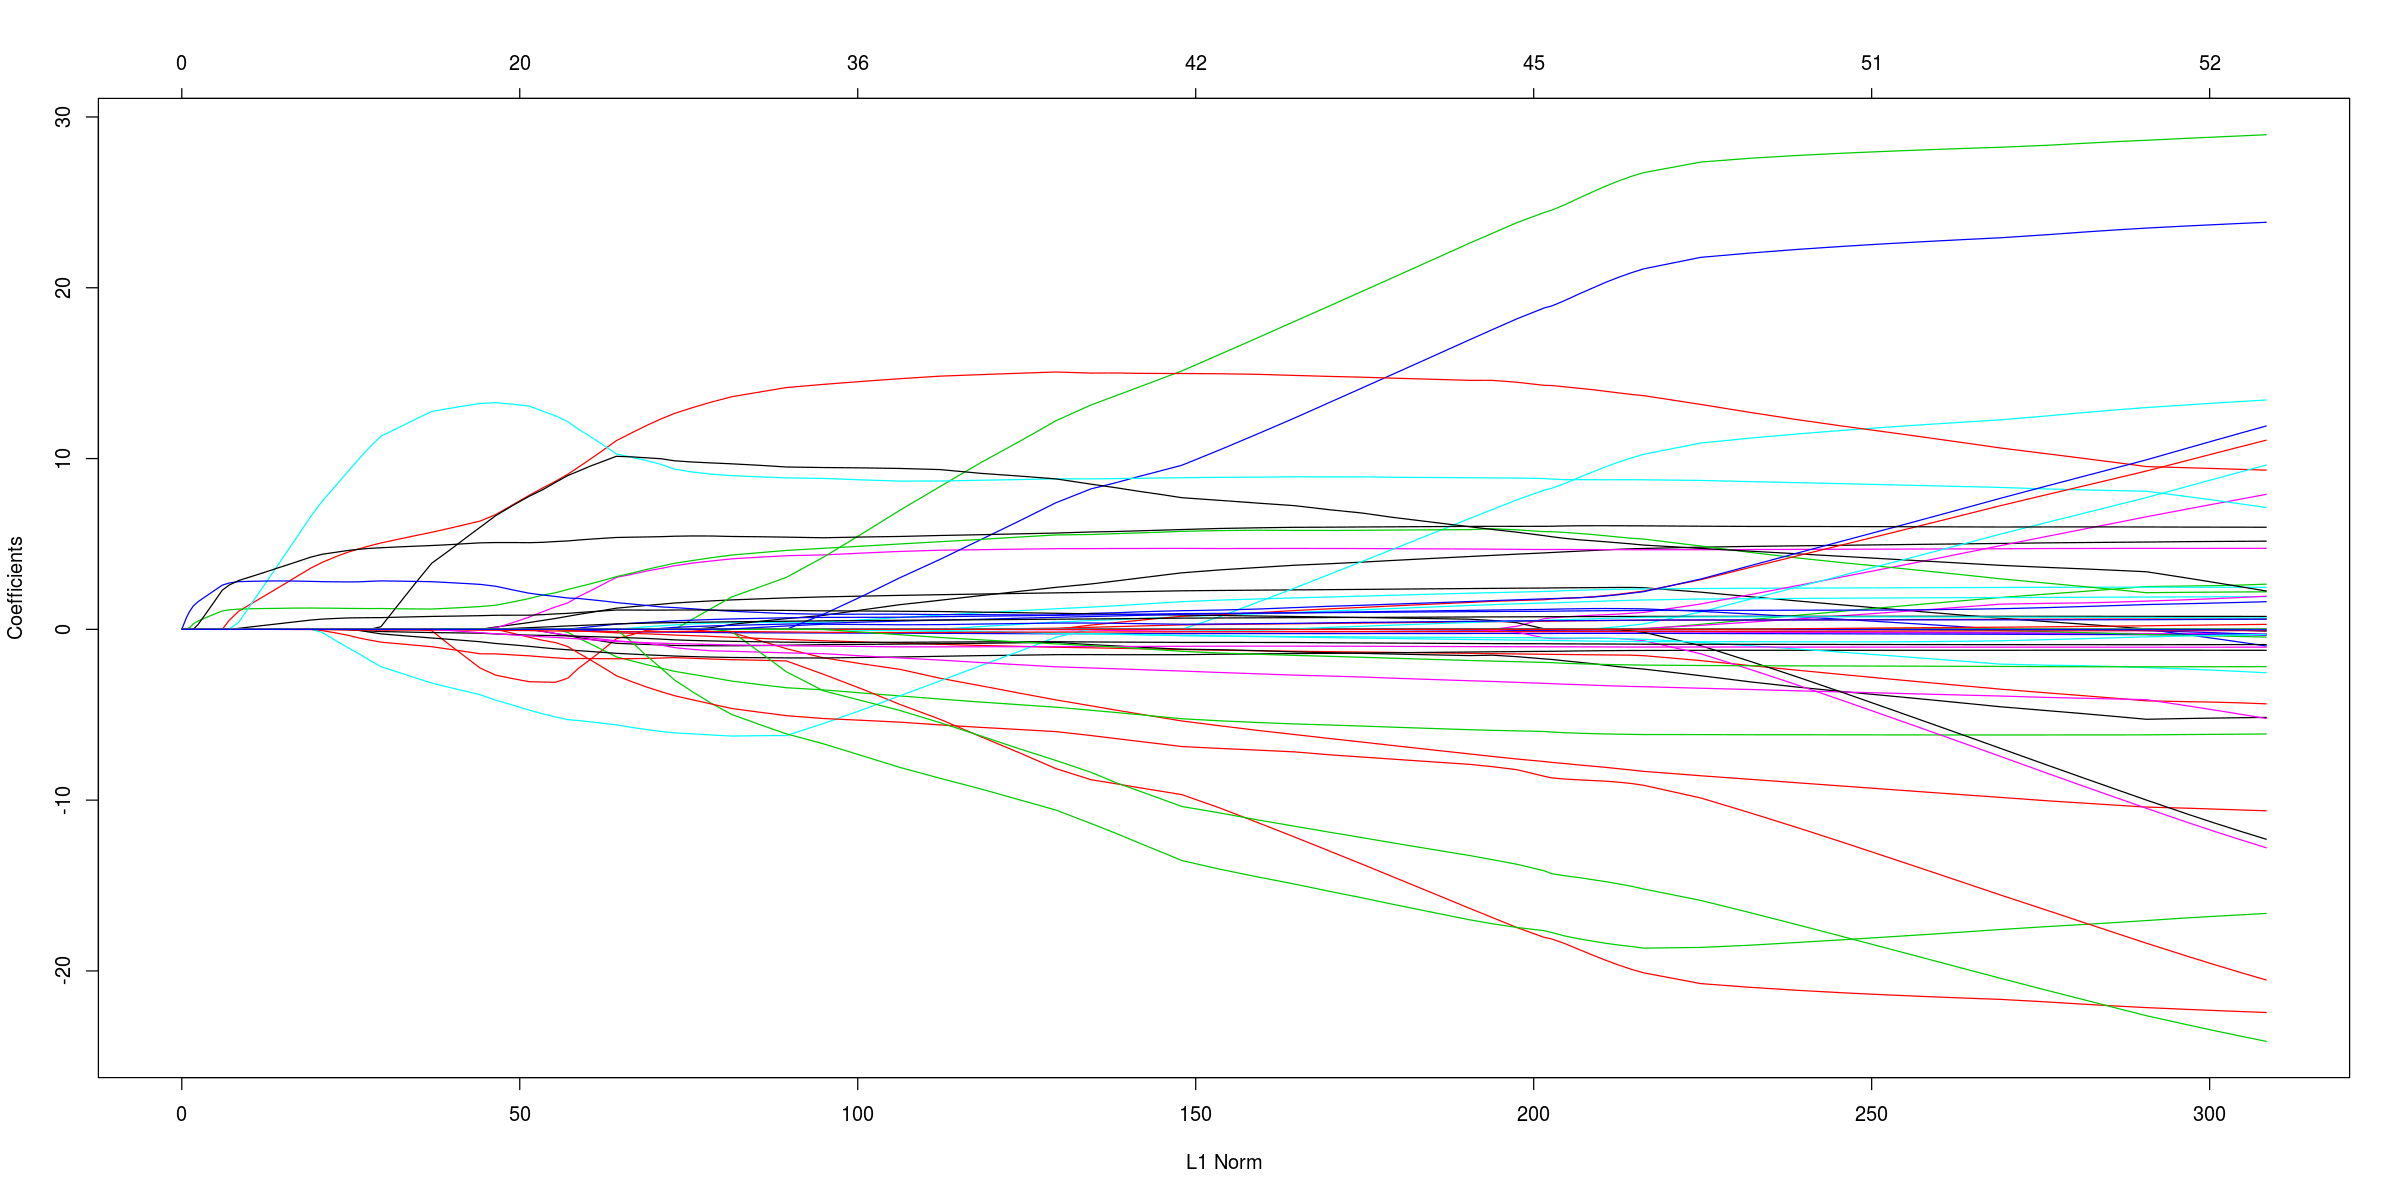

In [474]:
plot(m_enet)

#### Cross validation

In [475]:
enet.out <- cv.glmnet(as.matrix(data_but), data_tot$Points, alpha = 0.5)

In [476]:
bestlam_enet <- enet.out$lambda.min

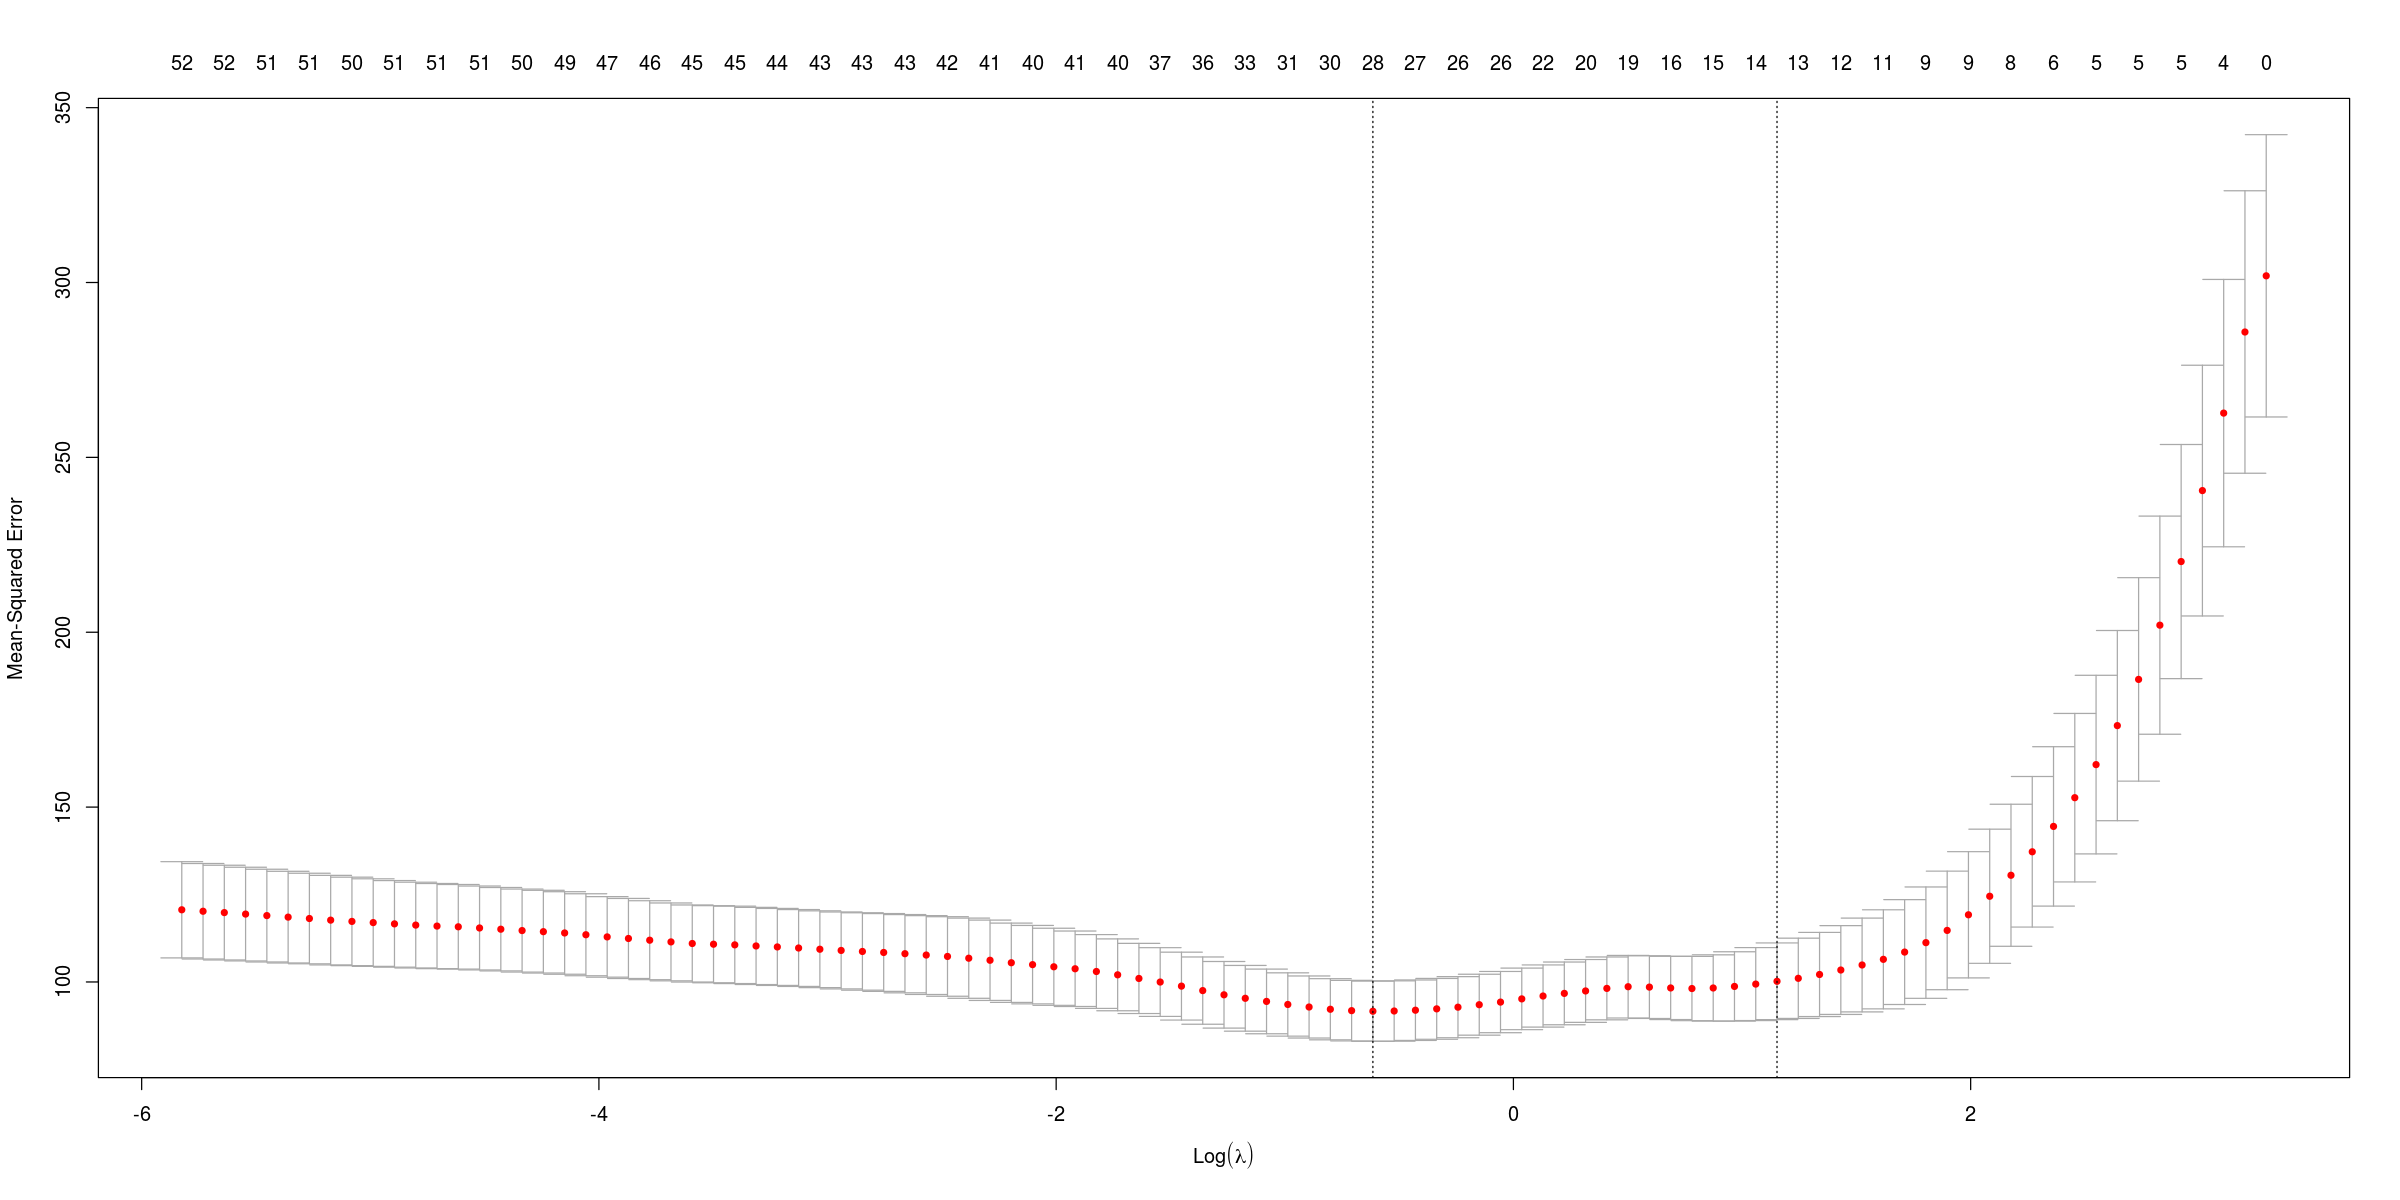

In [477]:
plot(enet.out)

In [478]:
elasticnet.predict = predict(enet.out, type = "coefficients", s = bestlam_enet)
elasticnet.predict

53 x 1 sparse Matrix of class "dgCMatrix"
                                            1
(Intercept)                       -7.79359753
Tackles_TotalTackles               1.39810244
Tackles_DribbledPast              -0.26195617
Tackles_TotalAttemptedTackles      .         
Interception_Total                 .         
Fouls_Fouled                       0.14640697
Fouls_Fouls                        .         
Cards_Yellow                       .         
Cards_Red                         -0.06205221
OffSides_CaughtOffside            -2.05925745
Clearances_Total                  -0.15255234
Blocks_ShotsBlocked                .         
Blocks_CrossesBlocked              3.40623464
Blocks_PassesBlocked              -1.49112456
Saves_Total                       -1.70593635
Saves_SixYardBox                   .         
Saves_PenaltyArea                  .         
Saves_OutOfBox                    -5.86202339
Shots_Total                        .         
ShotsZones_OutOfBox               -0.8

In [479]:
elasticnet.summary = summary(elasticnet.predict)

In [480]:
for (i in 1:(length(elasticnet.summary[,1])-1)){
    df.variables.points$ElasticNet[elasticnet.summary[i+1,1]-1] = round(elasticnet.summary[i+1,3],3)
}

In [481]:
df.variables.points

Noms,BIC,Lasso,ElasticNet
<fct>,<dbl>,<dbl>,<dbl>
Tackles_TotalTackles,0.000,1.339,1.398
Tackles_DribbledPast,0.000,-0.188,-0.262
Tackles_TotalAttemptedTackles,0.000,0.000,0.000
Interception_Total,0.000,0.000,0.000
Fouls_Fouled,0.000,0.102,0.146
Fouls_Fouls,0.000,0.000,0.000
Cards_Yellow,0.000,0.000,0.000
Cards_Red,0.000,0.000,-0.062
OffSides_CaughtOffside,0.000,-1.985,-2.059


### REPRÉSENTATION DES RÉSULTATS tous pays confondus

In [482]:
for (i in 2:length(df.variables.points)){
    m = max(abs(df.variables.points[,i]))
    df.variables.points[,i] = df.variables.points[,i]/m
}

df.points.sans_zeros = df.variables.points[rowSums(df.variables.points[,2:4]^2) > 0, ]

In [483]:
mat.variables.points = data.matrix(df.points.sans_zeros[,2:4])

In [484]:
rownames(mat.variables.points) = df.points.sans_zeros$Noms

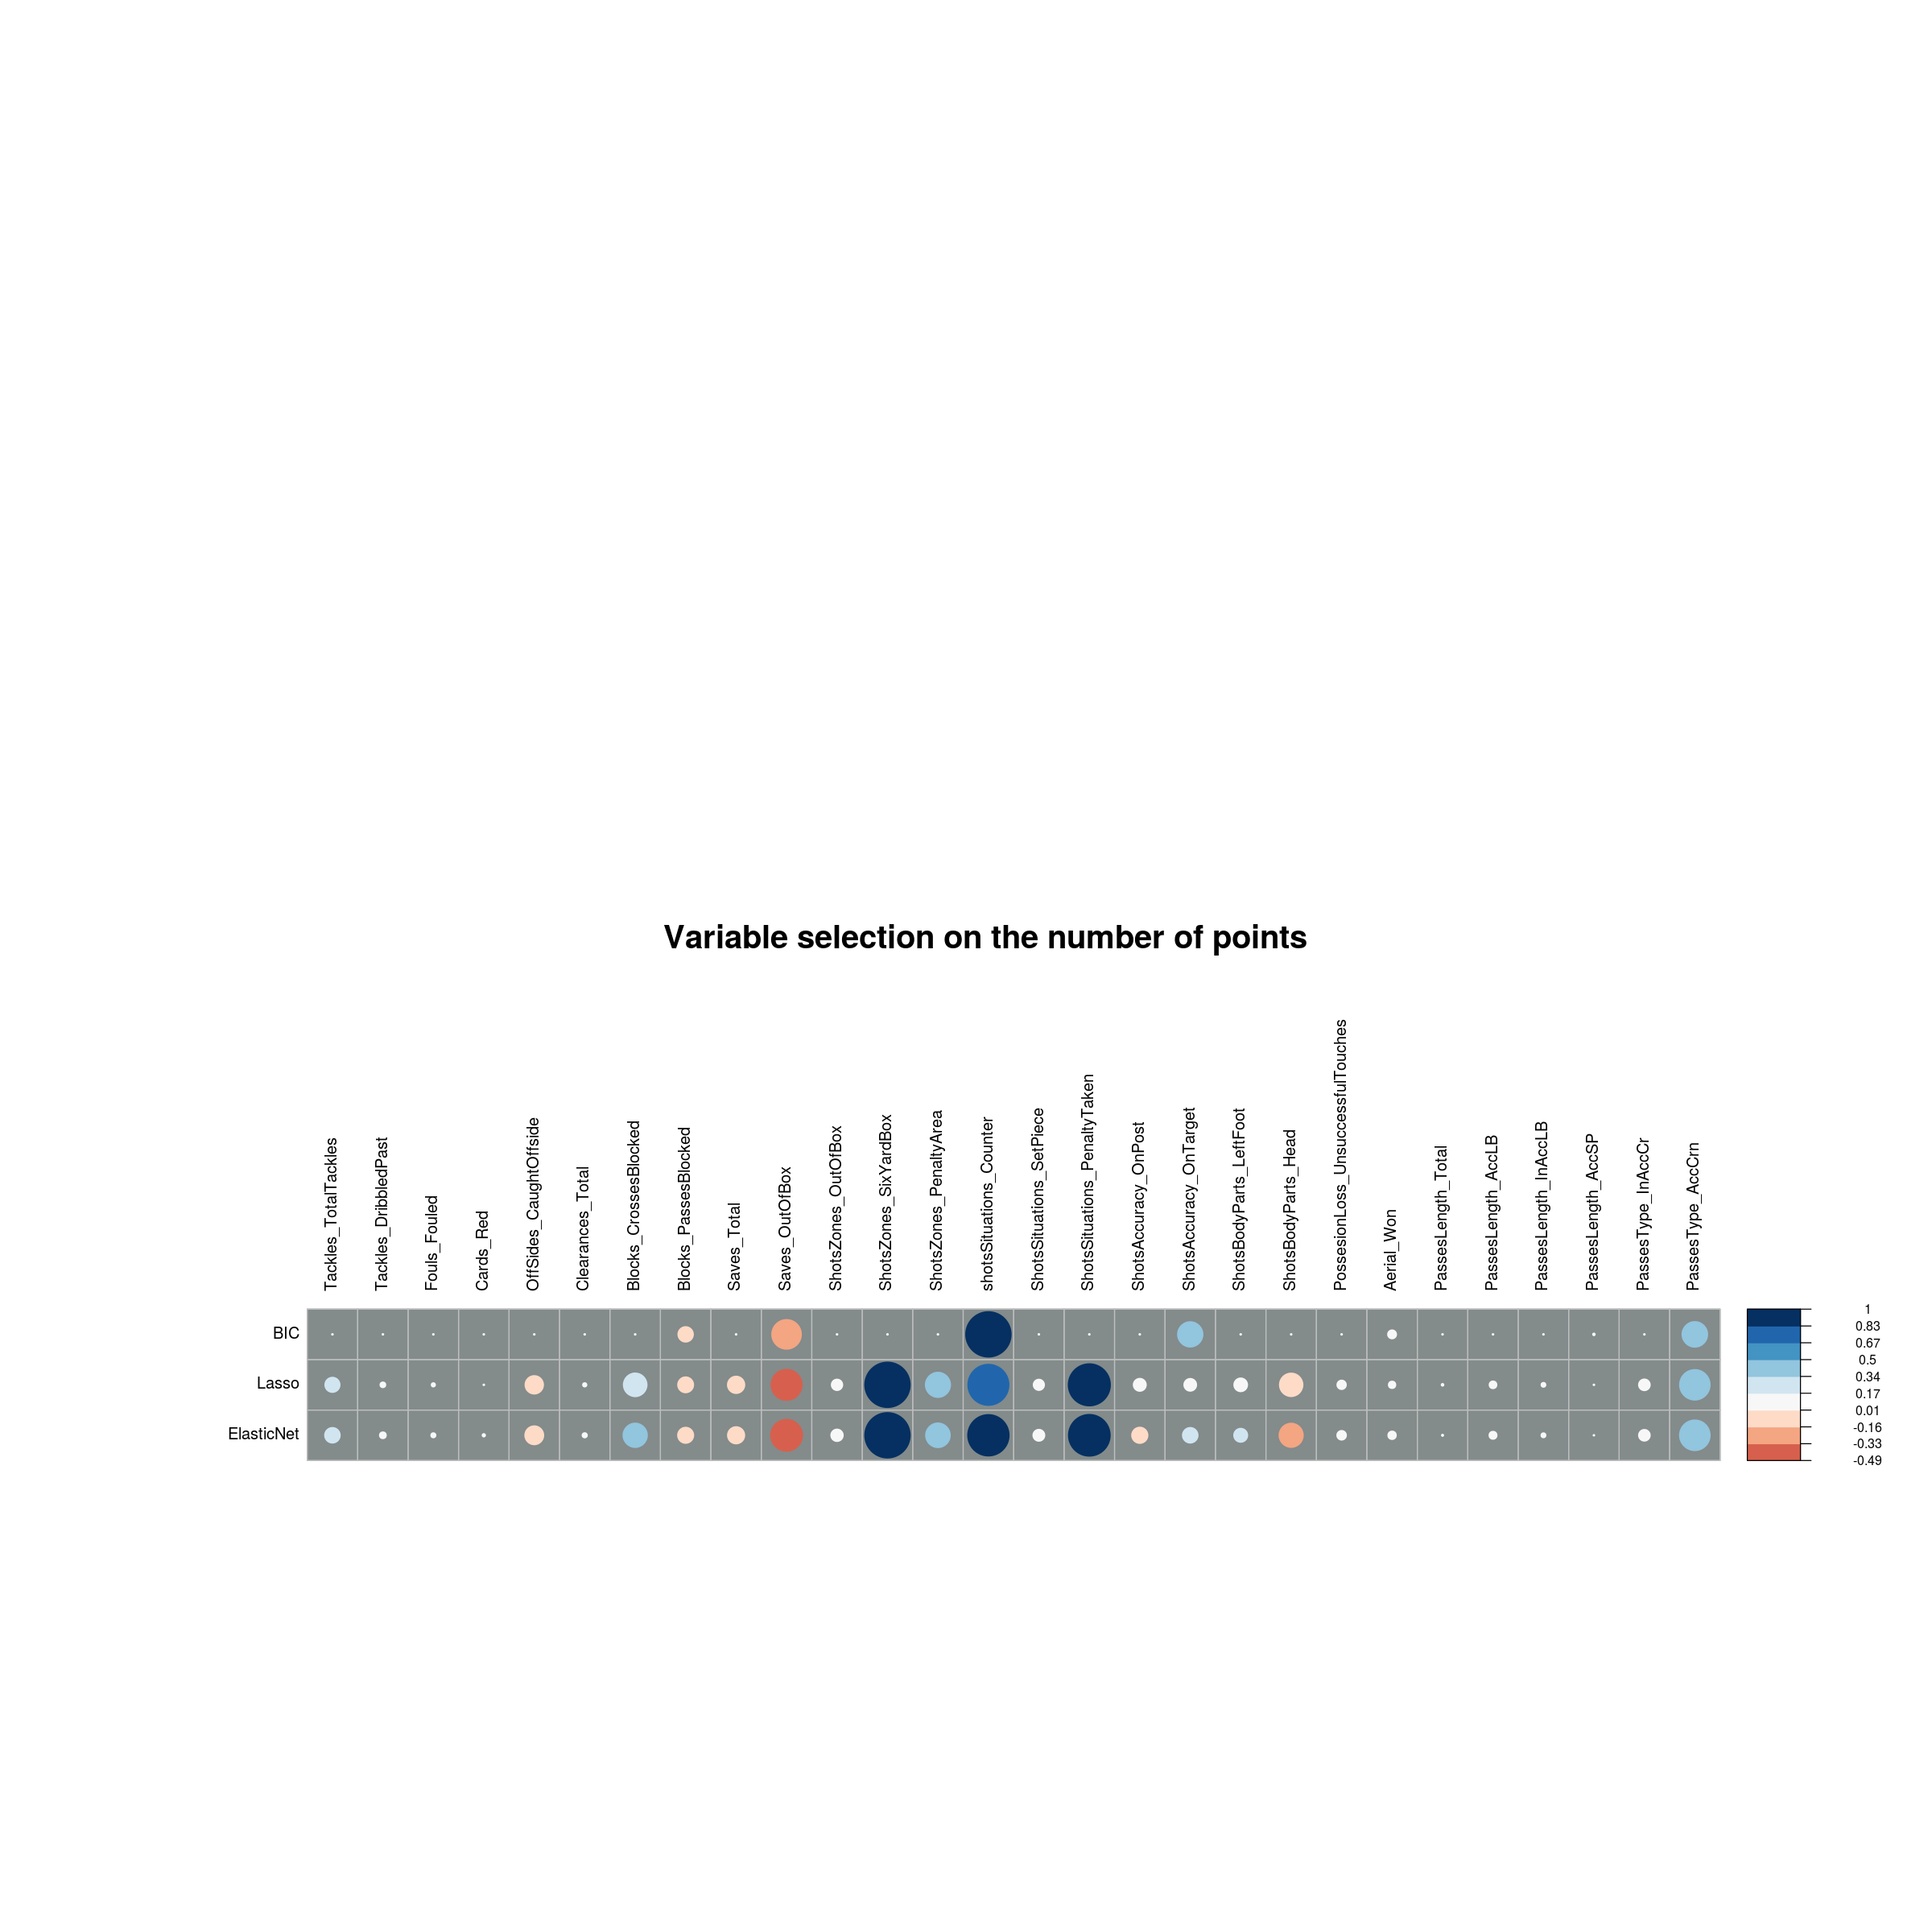

In [485]:
options(repr.plot.width=20, repr.plot.height=20)
corrplot(t(mat.variables.points), is.corr = FALSE, method = "circle", tl.col = 1, bg = "azure4", col = brewer.pal(n = 11, name = "RdBu"))#, main = "Nombre de points")#, col = c("blue", "red"))#, col = col1(100))
title("Variable selection on the number of points", line = -45, cex.main = 2)

### LASSO sur les pays

In [486]:
lasso_france = cv.glmnet(as.matrix(France), data_tot[data_tot$Pays=="France",]$Points, alpha = 1)
bestlam_lasso_france <- lasso_france$lambda.min
#plot(lasso_france)
lasso.france.predict = predict(lasso_france, type = "coefficients", s = bestlam_lasso_france)
lasso.summary.france = summary(lasso.france.predict)

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”


In [487]:
for (i in 1:(length(lasso.summary.france[,1])-1)){
    df.variables.pays$France_LASSO[lasso.summary.france[i+1,1]-1] = round(lasso.summary.france[i+1,3],3)
}

ERROR: Error in `$<-.data.frame`(`*tmp*`, "France_LASSO", value = c(NA, NA, NA, : replacement has 10 rows, data has 52


In [ ]:
lasso_allemagne = cv.glmnet(as.matrix(Allemagne), data_tot[data_tot$Pays=="Allemagne",]$Points, alpha = 1)
bestlam_lasso_allemagne <- lasso_allemagne$lambda.min
#plot(lasso_allemagne)
lasso.allemagne.predict = predict(lasso_allemagne, type = "coefficients", s = bestlam_lasso_allemagne)
lasso.summary.allemagne = summary(lasso.allemagne.predict)

In [ ]:
for (i in 1:(length(lasso.summary.allemagne[,1])-1)){
    df.variables.pays$Allemagne_LASSO[lasso.summary.allemagne[i+1,1]-1] = round(lasso.summary.allemagne[i+1,3],3)
}

In [ ]:
lasso_italie = cv.glmnet(as.matrix(Italie), data_tot[data_tot$Pays=="Italie",]$Points, alpha = 1)
bestlam_lasso_italie <- lasso_italie$lambda.min
#plot(lasso_italie)
lasso.italie.predict = predict(lasso_italie, type = "coefficients", s = bestlam_lasso_italie)
lasso.summary.italie = summary(lasso.italie.predict)

In [ ]:
for (i in 1:(length(lasso.summary.italie[,1])-1)){
    df.variables.pays$Italie_LASSO[lasso.summary.italie[i+1,1]-1] = round(lasso.summary.italie[i+1,3],3)
}

In [ ]:
lasso_espagne = cv.glmnet(as.matrix(Espagne), data_tot[data_tot$Pays=="Espagne",]$Points, alpha = 1)
bestlam_lasso_espagne <- lasso_espagne$lambda.min
#plot(lasso_espagne)
lasso.espagne.predict = predict(lasso_espagne, type = "coefficients", s = bestlam_lasso_espagne)
lasso.summary.espagne = summary(lasso.espagne.predict)

In [ ]:
for (i in 1:(length(lasso.summary.espagne[,1])-1)){
    df.variables.pays$Espagne_LASSO[lasso.summary.espagne[i+1,1]-1] = round(lasso.summary.espagne[i+1,3],3)
}

In [ ]:
lasso_argentine = cv.glmnet(as.matrix(Argentine), data_tot[data_tot$Pays=="Argentine",]$Points, alpha = 1)
bestlam_lasso_argentine <- lasso_argentine$lambda.min
#plot(lasso_argentine)
lasso.argentine.predict = predict(lasso_argentine, type = "coefficients", s = bestlam_lasso_argentine)
lasso.summary.argentine = summary(lasso.argentine.predict)

In [ ]:
for (i in 1:(length(lasso.summary.argentine[,1])-1)){
    df.variables.pays$Argentine_LASSO[lasso.summary.argentine[i+1,1]-1] = round(lasso.summary.argentine[i+1,3],3)
}

In [ ]:
lasso_angleterre = cv.glmnet(as.matrix(Angleterre), data_tot[data_tot$Pays=="Angleterre",]$Points, alpha = 1)
bestlam_lasso_angleterre <- lasso_angleterre$lambda.min
#plot(lasso_angleterre)
lasso.angleterre.predict = predict(lasso_angleterre, type = "coefficients", s = bestlam_lasso_angleterre)
lasso.summary.angleterre = summary(lasso.angleterre.predict)

In [ ]:
for (i in 1:(length(lasso.summary.angleterre[,1])-1)){
    df.variables.pays$Angleterre_LASSO[lasso.summary.angleterre[i+1,1]-1] = round(lasso.summary.angleterre[i+1,3],3)
}

### ElasticNet sur les pays

In [488]:
enet_france = cv.glmnet(as.matrix(France), data_tot[data_tot$Pays=="France",]$Points, alpha = 0.5)
bestlam_enet_france <- enet_france$lambda.min
#plot(enet_france)
enet.france.predict = predict(enet_france, type = "coefficients", s = bestlam_enet_france)
enet.summary.france = summary(enet.france.predict)

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”


In [511]:
for (i in 1:(length(enet.summary.france[,1])-1)){
    df.variables.pays$France_ElasticNet[enet.summary.france[i+1,1]-1] = round(enet.summary.france[i+1,3],3)
}

In [491]:
enet_allemagne = cv.glmnet(as.matrix(Allemagne), data_tot[data_tot$Pays=="Allemagne",]$Points, alpha = 0.5)
bestlam_enet_allemagne <- enet_allemagne$lambda.min
#plot(enet_allemagne)
enet.allemagne.predict = predict(enet_allemagne, type = "coefficients", s = bestlam_enet_allemagne)
enet.summary.allemagne = summary(enet.allemagne.predict)

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”


In [512]:
for (i in 1:(length(enet.summary.allemagne[,1])-1)){
    df.variables.pays$Allemagne_ElasticNet[enet.summary.allemagne[i+1,1]-1] = round(enet.summary.allemagne[i+1,3],3)
}

In [493]:
enet_italie = cv.glmnet(as.matrix(Italie), data_tot[data_tot$Pays=="Italie",]$Points, alpha = 0.5)
bestlam_enet_italie <- enet_italie$lambda.min
#plot(enet_italie)
enet.italie.predict = predict(enet_italie, type = "coefficients", s = bestlam_enet_italie)
enet.summary.italie = summary(enet.italie.predict)

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”


In [513]:
for (i in 1:(length(enet.summary.italie[,1])-1)){
    df.variables.pays$Italie_ElasticNet[enet.summary.italie[i+1,1]-1] = round(enet.summary.italie[i+1,3],3)
}

In [495]:
enet_espagne = cv.glmnet(as.matrix(Espagne), data_tot[data_tot$Pays=="Espagne",]$Points, alpha = 0.5)
bestlam_enet_espagne <- enet_espagne$lambda.min
#plot(enet_espagne)
enet.espagne.predict = predict(enet_espagne, type = "coefficients", s = bestlam_enet_espagne)
enet.summary.espagne = summary(enet.espagne.predict)

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”


In [514]:
for (i in 1:(length(enet.summary.espagne[,1])-1)){
    df.variables.pays$Espagne_ElasticNet[enet.summary.espagne[i+1,1]-1] = round(enet.summary.espagne[i+1,3],3)
}

In [497]:
enet_argentine = cv.glmnet(as.matrix(Argentine), data_tot[data_tot$Pays=="Argentine",]$Points, alpha = 0.5)
bestlam_enet_argentine <- enet_argentine$lambda.min
#plot(enet_argentine)
enet.argentine.predict = predict(enet_argentine, type = "coefficients", s = bestlam_enet_argentine)
enet.summary.argentine = summary(enet.argentine.predict)

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”


In [515]:
for (i in 1:(length(enet.summary.argentine[,1])-1)){
    df.variables.pays$Argentine_ElasticNet[enet.summary.argentine[i+1,1]-1] = round(enet.summary.argentine[i+1,3],3)
}

In [499]:
enet_angleterre = cv.glmnet(as.matrix(Angleterre), data_tot[data_tot$Pays=="Angleterre",]$Points, alpha = 0.5)
bestlam_enet_angleterre <- enet_angleterre$lambda.min
#plot(enet_angleterre)
enet.angleterre.predict = predict(enet_angleterre, type = "coefficients", s = bestlam_enet_angleterre)
enet.summary.angleterre = summary(enet.angleterre.predict)

Warning message:
“Option grouped=FALSE enforced in cv.glmnet, since < 3 observations per fold”


In [516]:
for (i in 1:(length(enet.summary.angleterre[,1])-1)){
    df.variables.pays$Angleterre_ElasticNet[enet.summary.angleterre[i+1,1]-1] = round(enet.summary.angleterre[i+1,3],3)
}

In [517]:
# normalisation

for (i in 2:length(df.variables.pays)){
    m = max(abs(df.variables.pays[,i]))
    df.variables.pays[,i] = df.variables.pays[,i]/m
}
#df2 = df.variables.pays[,-c(3,6,9,12,15,18)]

In [518]:
df.variables.pays

Noms,France_ElasticNet,Espagne_ElasticNet,Italie_ElasticNet,Argentine_ElasticNet,Angleterre_ElasticNet,Allemagne_ElasticNet
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Tackles_TotalTackles,0.0000000000,0.000000000,0.00000000,0.000000000,0.000000000,0.00000000
Tackles_DribbledPast,0.0000000000,0.000000000,-0.20704708,0.000000000,0.000000000,0.00000000
Tackles_TotalAttemptedTackles,0.0000000000,0.000000000,0.00000000,0.000000000,0.000000000,0.00000000
Interception_Total,0.0000000000,0.000000000,0.00000000,0.000000000,-0.003459990,0.00000000
Fouls_Fouled,0.0000000000,0.000000000,0.00000000,0.000000000,0.000000000,0.00000000
Fouls_Fouls,0.0000000000,-0.089817090,0.00000000,0.000000000,0.000000000,0.00000000
Cards_Yellow,0.0000000000,0.000000000,0.00000000,0.000000000,0.000000000,0.00000000
Cards_Red,0.0000000000,0.000000000,-0.96528427,-0.312572895,0.000000000,0.00000000
OffSides_CaughtOffside,0.0000000000,0.000000000,0.00000000,0.000000000,0.000000000,0.00000000


In [521]:
df.pays.sans_zeros = df.variables.pays[rowSums(df.variables.pays[,2:7]^2) > 0, ]
mat.pays = data.matrix(df.pays.sans_zeros[,2:7])

In [522]:
mat.pays

,France_ElasticNet,Espagne_ElasticNet,Italie_ElasticNet,Argentine_ElasticNet,Angleterre_ElasticNet,Allemagne_ElasticNet
2,0.0000000000,0.000000000,-0.20704708,0.000000000,0.000000000,0.00000000
4,0.0000000000,0.000000000,0.00000000,0.000000000,-0.003459990,0.00000000
6,0.0000000000,-0.089817090,0.00000000,0.000000000,0.000000000,0.00000000
8,0.0000000000,0.000000000,-0.96528427,-0.312572895,0.000000000,0.00000000
10,-0.0870674357,0.000000000,-0.00748363,0.000000000,0.000000000,0.00000000
11,0.0000000000,0.000000000,0.00000000,0.000000000,0.000000000,-1.00000000
12,0.0000000000,-1.000000000,0.00000000,0.000000000,0.000000000,0.00000000
14,0.0000000000,0.000000000,-0.13273049,0.000000000,-0.009058883,0.00000000
17,0.0000000000,0.000000000,-1.00000000,0.000000000,0.000000000,-0.28976767
18,0.0037710736,0.106470106,0.00000000,0.054583625,0.007611978,0.00000000


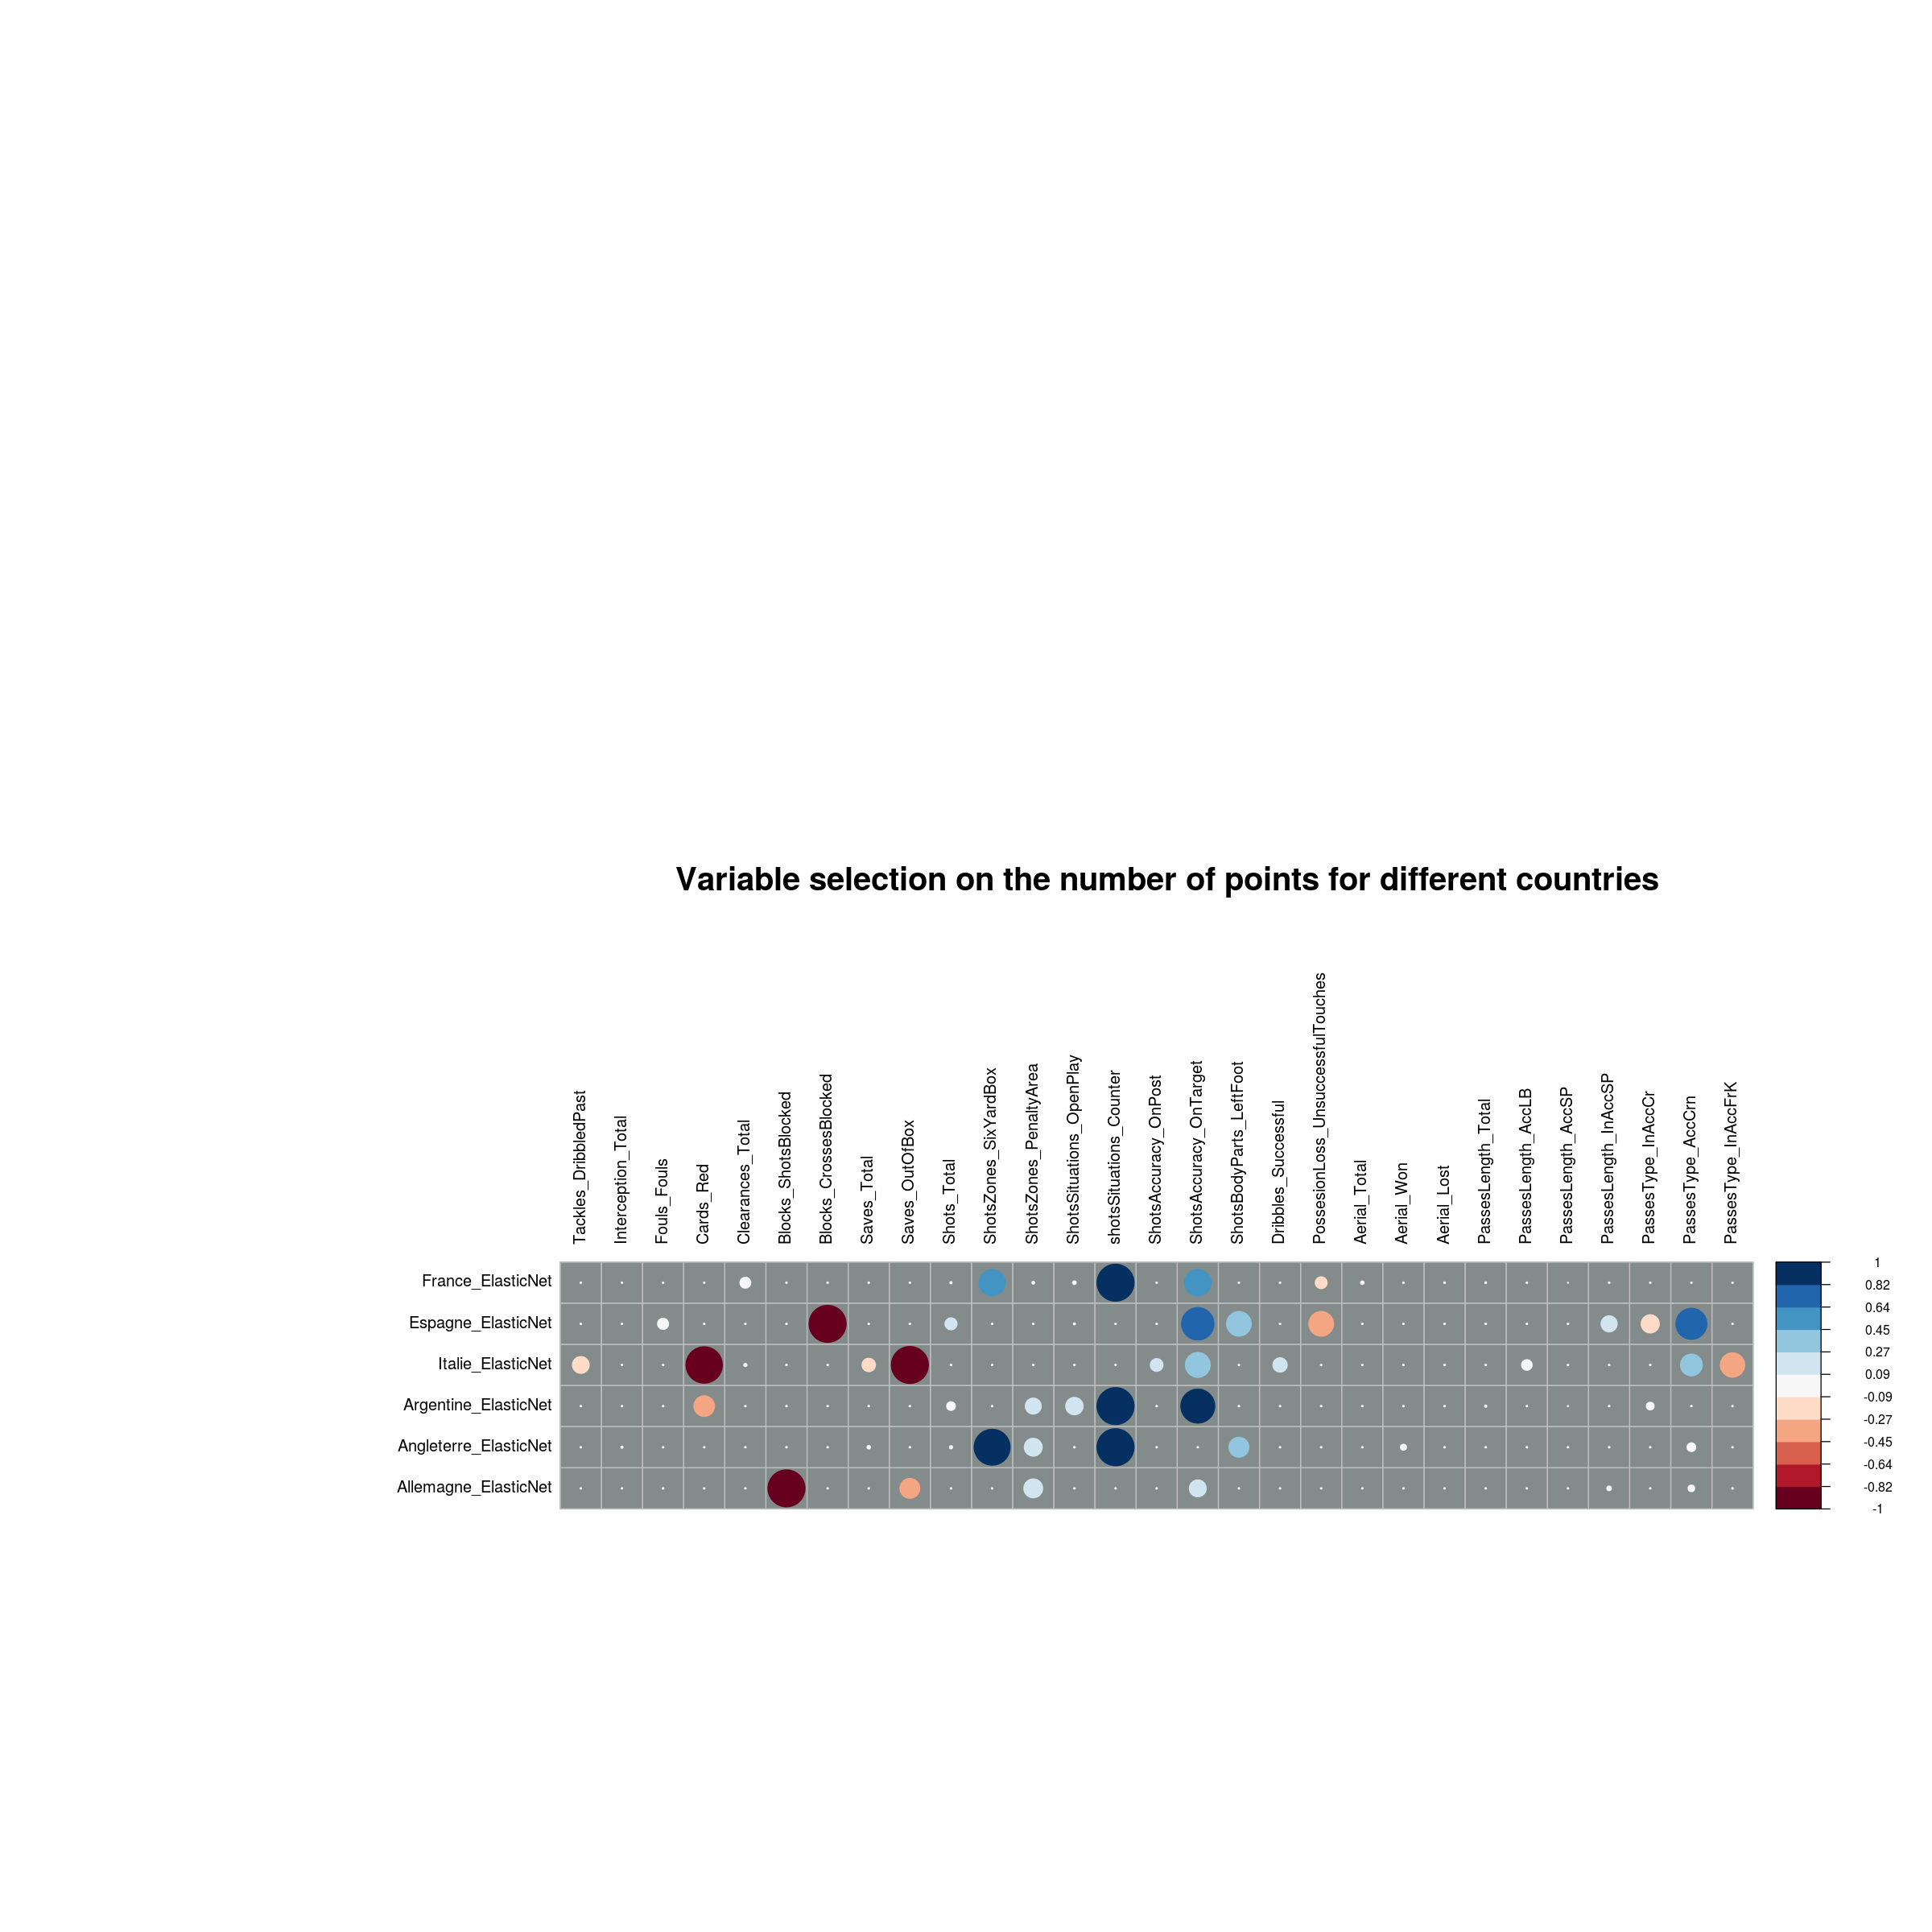

In [523]:
rownames(mat.pays) = df.pays.sans_zeros$Noms
options(repr.plot.width=20, repr.plot.height=20)
corrplot(t(mat.pays), is.corr = FALSE, method = "circle", tl.col = 1, bg = "azure4", col = brewer.pal(n = 11, name = "RdBu"))
title("                                         Variable selection on the number of points for different countries", line = -42, cex.main = 2)